In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
flag = True  # Set this flag as needed
name = "Preprocessed_Data_new.csv" if flag == True else "Mall_Customers.csv"
df = pd.read_csv(name)
if name == "Mall_Customers.csv":
    df = df.drop(columns=['CustomerID'])
    df['Genre'] = df['Genre'].map({'Male': 1, 'Female': 0})
    ss = StandardScaler()
    df[ df.columns ] = ss.fit_transform( df[ df.columns ] )
df

,Age Annual Income (k$),AgeGroup_61-69,Annual Income (k$),IncomeBin_Q1,IncomeBin_Q2,IncomeBin_Q3,Income_per_Age
0,-1.699593,-0.290292,-1.866777,1.646675,-0.591312,-0.623289,-1.137799
1,-1.655382,-0.290292,-1.825592,1.646675,-0.591312,-0.623289,-1.158515
2,-1.522749,-0.290292,-1.784407,1.646675,-0.591312,-0.623289,-1.322240
3,-1.650377,-0.290292,-1.784407,1.646675,-0.591312,-0.623289,-1.072825
4,-1.436830,-0.290292,-1.743222,1.646675,-0.591312,-0.623289,-1.360152
...,...,...,...,...,...,...,...
188,1.148263,-0.290292,2.169371,-0.607284,-0.591312,-0.623289,1.875047
189,1.619569,-0.290292,2.169371,-0.607284,-0.591312,-0.623289,1.374131
190,2.742362,-0.290292,2.457667,-0.607284,-0.591312,-0.623289,0.906640
191,1.541157,-0.290292,2.457667,-0.607284,-0.591312,-0.623289,1.879860


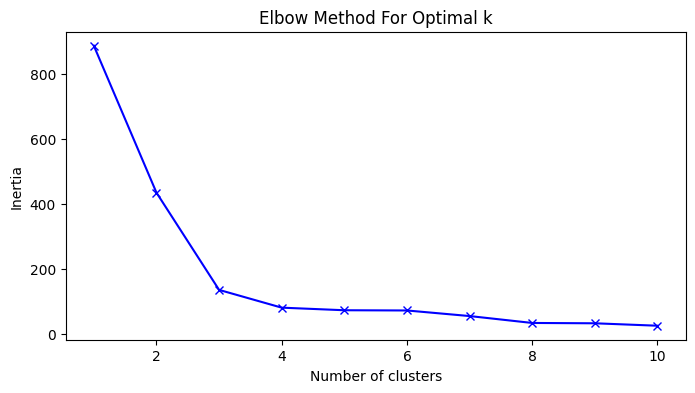

In [2]:
# get number of clusters using elbow method
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

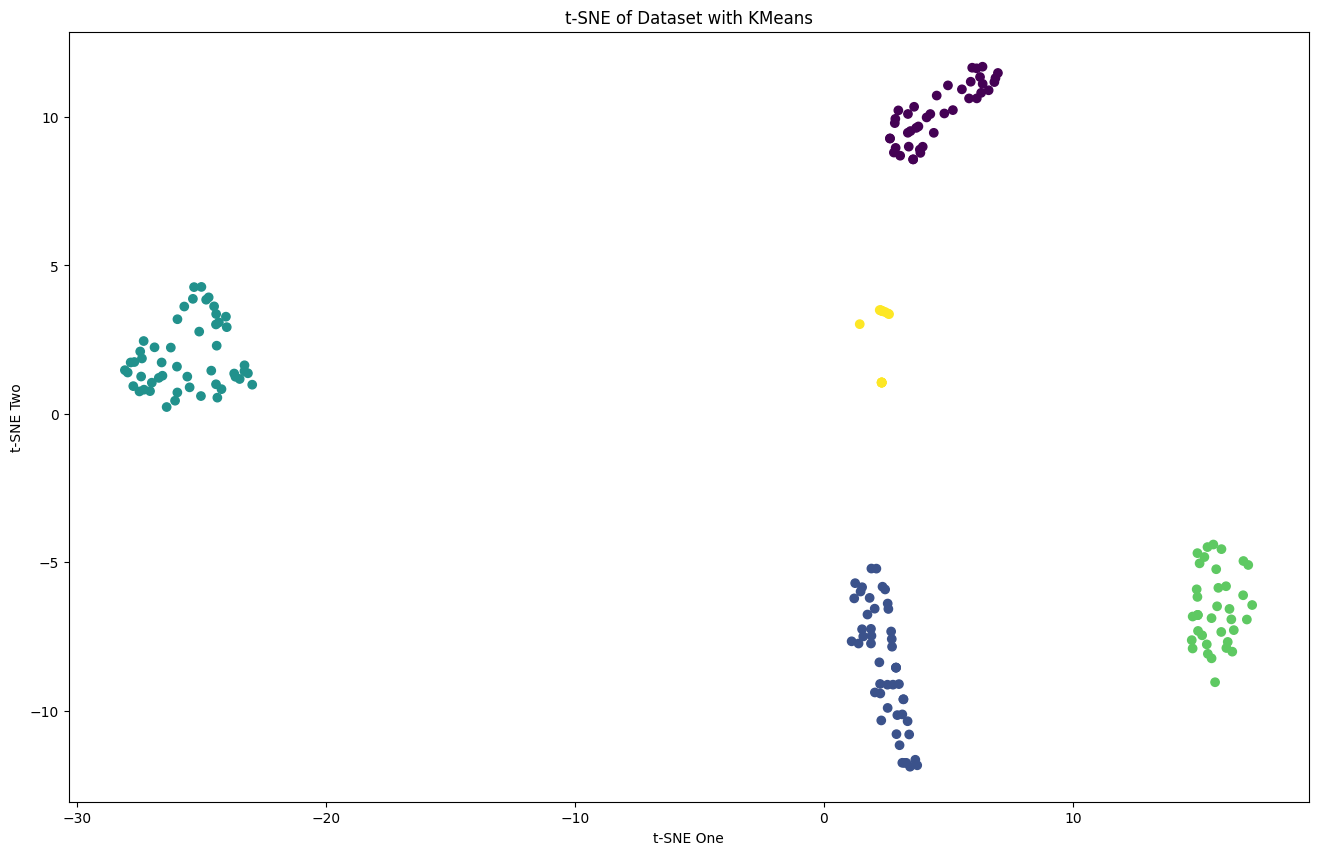

In [3]:
# Kmeans 聚类t-SNE降维结果
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

data_kmeans = df.copy() # already preprocessed
# apply clustering algorithm
Kmeans = KMeans(n_clusters=5, random_state=42)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_kmeans)
data_kmeans['tsne-one'] = tsne_result[:,0]
data_kmeans['tsne-two'] = tsne_result[:,1]
data_kmeans['cluster'] = Kmeans.fit_predict(data_kmeans[['tsne-one', 'tsne-two']])
plt.figure(figsize=(16,10))
plt.scatter(data_kmeans['tsne-one'], data_kmeans['tsne-two'], c=data_kmeans['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE of Dataset with KMeans')
plt.show()

In [4]:
# Evaluation By Silhouette Coef and Calinski-harabasz
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_clustering(predicted_labels, data):
    # Filter out noise points (labeled as -1) for silhouette score calculation
    if -1 in predicted_labels:
        non_noise_indices = (predicted_labels != -1)
        if np.sum(non_noise_indices) > 1: # Silhouette score requires at least 2 labels
            silhouette = silhouette_score(data[non_noise_indices], predicted_labels[non_noise_indices])
            chs = calinski_harabasz_score(data[non_noise_indices], predicted_labels[non_noise_indices])
        else:
            silhouette = -1 # Not enough points to calculate
            chs = -1
    else:
        silhouette = silhouette_score(data, predicted_labels)
        chs = calinski_harabasz_score(data, predicted_labels)
    return silhouette, chs

,Age Annual Income (k$),AgeGroup_61-69,Annual Income (k$),IncomeBin_Q1,IncomeBin_Q2,IncomeBin_Q3,Income_per_Age
kmedoids_cluster,,,,,,,
0,-1.040,-0.218,-1.251,1.647,-0.591,-0.623,-0.915
1,0.302,0.056,0.466,-0.607,-0.591,1.604,0.426
2,1.051,-0.290,1.429,-0.607,-0.591,-0.623,1.006
3,-0.892,-0.290,-0.186,-0.607,1.691,-0.623,0.838
4,0.387,0.698,-0.293,-0.607,1.691,-0.623,-0.766



=== 聚类评估指标 ===
轮廓系数: 0.5279
Calinski-Harabasz指数: 143.00


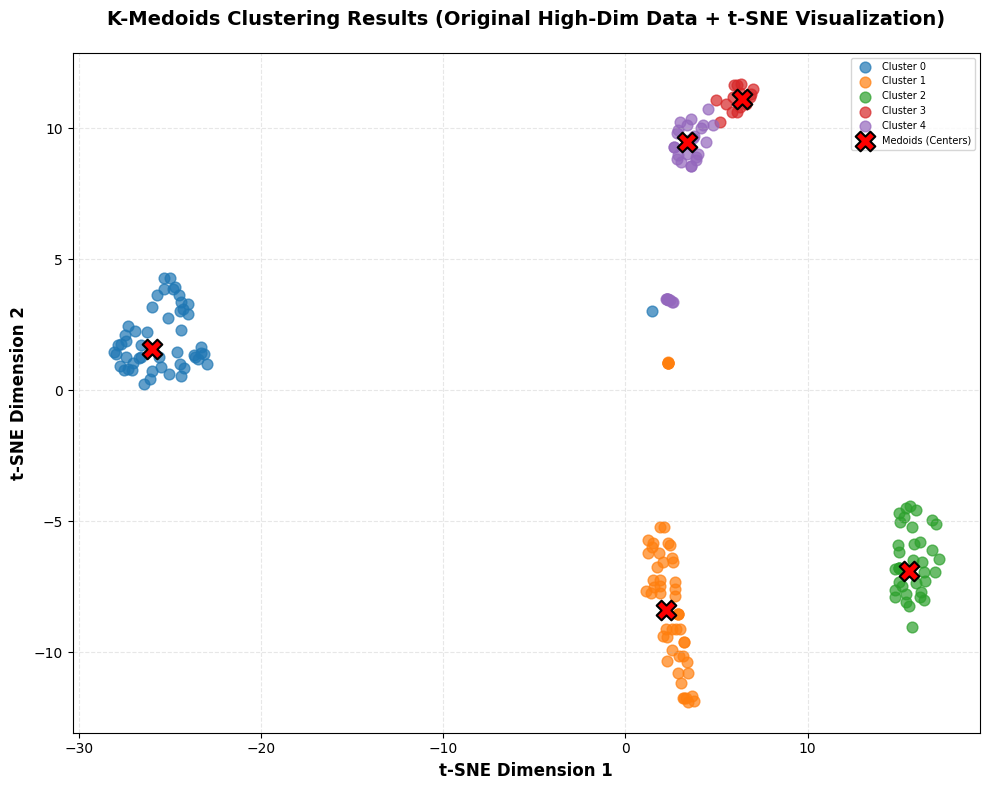

In [5]:
# clustering by k-medoids (PAM) - pure-Python implementation to avoid sklearn_extra binary dependency
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
import numpy as np

def kmedoids_pam(X, n_clusters, max_iter=300, random_state=42, metric='euclidean'):
    """PAM (Partitioning Around Medoids) with KMeans++-style initialization."""
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    # full pairwise distance matrix (Euclidean)
    D = pairwise_distances(X, metric=metric)

    def init_medoids_kpp(D, k, rng):
        """KMeans++-like initialization for medoids using distance matrix D."""
        n = D.shape[0]
        medoids = []
        # pick first medoid uniformly
        first = int(rng.integers(0, n))
        medoids.append(first)
        # pick remaining medoids
        for _ in range(1, k):
            # distance from each point to the nearest chosen medoid
            dist_to_nearest = np.min(D[:, medoids], axis=1)
            # squared distances (kmeans++ uses squared distances)
            probs = dist_to_nearest ** 2
            total = probs.sum()
            if total <= 0:
                # all distances zero -> pick randomly among remaining
                candidates = [i for i in range(n) if i not in medoids]
                if not candidates:
                    break
                next_medoid = int(rng.choice(candidates))
            else:
                probs = probs / total
                probs[medoids] = 0.0
                psum = probs.sum()
                if psum <= 0:
                    candidates = [i for i in range(n) if i not in medoids]
                    next_medoid = int(rng.choice(candidates))
                else:
                    next_medoid = int(rng.choice(n, p=probs))
            medoids.append(next_medoid)
        return np.array(medoids, dtype=int)

    # initialize medoids with kmeans++-like method
    medoids = init_medoids_kpp(D, n_clusters, rng)
    labels = np.argmin(D[:, medoids], axis=1)

    for _ in range(max_iter):
        changed = False
        for i in range(n_clusters):
            cluster_idx = np.where(labels == i)[0]
            if len(cluster_idx) == 0:
                continue
            # compute total distance for each candidate medoid inside the cluster
            subD = D[np.ix_(cluster_idx, cluster_idx)]
            costs = subD.sum(axis=1)
            new_medoid_local = cluster_idx[np.argmin(costs)]
            if new_medoid_local != medoids[i]:
                medoids[i] = new_medoid_local
                changed = True
        new_labels = np.argmin(D[:, medoids], axis=1)
        if not changed and np.all(labels==new_labels):
            break
        labels = new_labels
    return medoids, labels

# prepare data and run K-Medoids on 2D PCA projection
data_kmedoids = df.copy()  # already preprocessed
kmedoids_n = 5

X = data_kmedoids.copy()
medoids, labels = kmedoids_pam(
    X=X, 
    n_clusters=kmedoids_n, 
    random_state=42
)
# 5. Analyze the mean of the clusters
data_kmedoids['kmedoids_cluster'] = labels
cluster_stats = data_kmedoids.groupby('kmedoids_cluster').mean().round(3)
display(cluster_stats)


# 可视化之前，先把聚类标签从数据中删去，避免影响t-SNE结果
data_kmedoids = data_kmedoids.drop(columns=['kmedoids_cluster'])

print("\n=== 聚类评估指标 ===")
# 轮廓系数（越接近1越好，衡量簇内紧凑度与簇间分离度）
sil_score, chs_score = evaluate_clustering(labels, data_kmedoids)
# Calinski-Harabasz指数（越大越好，衡量簇间方差/簇内方差比）
print(f"轮廓系数: {sil_score:.4f}")
print(f"Calinski-Harabasz指数: {chs_score:.2f}")

# 6. t-SNE降维可视化（仅用于展示，不影响聚类结果）

# 对原始高维数据做t-SNE降维（映射到2D）
tsne = TSNE(n_components=2, random_state=42) 
tsne_result = tsne.fit_transform(data_kmedoids)

# 合并t-SNE结果与聚类标签
tsne_df = pd.DataFrame({
    't-SNE_1': tsne_result[:, 0],
    't-SNE_2': tsne_result[:, 1],
    'Cluster_Label': labels
})

# 绘制t-SNE聚类可视化图
plt.figure(figsize=(10, 8))
# 绘制各簇样本点
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'yellow', 'brown']  # 5簇配色，可扩展
for label in range(kmedoids_n):
    mask = tsne_df['Cluster_Label'] == label
    plt.scatter(
        tsne_df.loc[mask, 't-SNE_1'],
        tsne_df.loc[mask, 't-SNE_2'],
        c=colors[label],
        label=f'Cluster {label}',
        alpha=0.7,
        s=60
    )

# 标记K-Medoids质心（在t-SNE空间中的位置）
medoids_tsne = tsne_result[medoids]  # 质心的t-SNE坐标
plt.scatter(
    medoids_tsne[:, 0],
    medoids_tsne[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoids (Centers)',
    edgecolors='black',
    linewidth=1.5
)

# 图表美化与标签
plt.xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
plt.title('K-Medoids Clustering Results (Original High-Dim Data + t-SNE Visualization)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=7, loc='upper right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [6]:
# 假设已生成tsne_result（t-SNE降维结果）和df_scaled（标准化后的原始特征）
# 1. 构建t-SNE维度与原始特征的关联数据集
tsne_features = pd.DataFrame(tsne_result, columns=['t-SNE_1', 't-SNE_2'])
# 合并原始标准化特征
corr_df = pd.concat([data_kmedoids.reset_index(drop=True), tsne_features.reset_index(drop=True)], axis=1)

# 2. 计算原始特征与t-SNE维度的皮尔逊相关系数（核心：量化特征贡献）
correlation_matrix = corr_df.corr()[['t-SNE_1', 't-SNE_2']].round(3)
print("=== 原始特征与t-SNE维度的相关系数 ===")
display(correlation_matrix)

# 示例解读：若"Annual Income (k$)"与t-SNE_1的相关系数为0.8，说明t-SNE_1主要反映年收入的差异

=== 原始特征与t-SNE维度的相关系数 ===


,t-SNE_1,t-SNE_2
Age Annual Income (k$),0.695,-0.308
AgeGroup_61-69,0.083,0.129
Annual Income (k$),0.875,-0.558
IncomeBin_Q1,-0.937,0.210
IncomeBin_Q2,0.242,0.781
IncomeBin_Q3,0.184,-0.614
Income_per_Age,0.650,-0.494
t-SNE_1,1.000,-0.267
t-SNE_2,-0.267,1.000


In [7]:
# K-medoids 调参 By Grid Search
param_grid = {
    'n_clusters': [3, 4, 5, 6, 7, 8, 9],          # 簇数：初次选取3，新增4~6验证业务可解释性
    'max_iter': [300, 500, 800],      # 迭代次数：原文为300，新增500/800确保收敛
    'metric': ['euclidean', 'manhattan']  # 距离度量：原文为欧氏，新增曼哈顿（抗异常值）
}
res = []

for n_clusters in param_grid['n_clusters']:
    for max_iter in param_grid['max_iter']:
        for metric in param_grid['metric']:
            # 运行K-Medoids聚类
            meds, lbs = kmedoids_pam(
                X=X,
                n_clusters=n_clusters,
                max_iter=max_iter,
                random_state=42,
                metric=metric
            )
            silhouette, CHS = evaluate_clustering(lbs, X)
            res.append({
                'n_clusters': n_clusters,
                'max_iter': max_iter,
                'metric': metric,
                'silhouette_score': silhouette,
                'calinski_harabasz_score': CHS,
                'medoids': meds,
                'labels': lbs
            })

results_df = pd.DataFrame(res)
# 按silhouette score 降序排列
best_param = results_df.sort_values('silhouette_score', ascending=False).iloc[0]
print("=== K-Medoids 最优超参组合 ===")
print(f"簇数 (n_clusters): {best_param['n_clusters']}")
print(f"最大迭代次数 (max_iter): {best_param['max_iter']}")
print(f"距离度量 (metric): {best_param['metric']}")
print(f"轮廓系数 (Silhouette): {best_param['silhouette_score']:.4f}")
print(f"Calinski-Harabasz指数: {best_param['calinski_harabasz_score']:.2f}")
# results_df
# best_param

=== K-Medoids 最优超参组合 ===
簇数 (n_clusters): 7
最大迭代次数 (max_iter): 500
距离度量 (metric): euclidean
轮廓系数 (Silhouette): 0.6002
Calinski-Harabasz指数: 229.75


,n_clusters,silhouette_score,calinski_harabasz_score
0,3,0.513602,141.612737
1,4,0.553464,154.819664
2,5,0.527877,143.003905
3,6,0.505765,125.536532
4,7,0.600210,229.754423
5,8,0.577128,247.846011
6,9,0.494060,239.770199


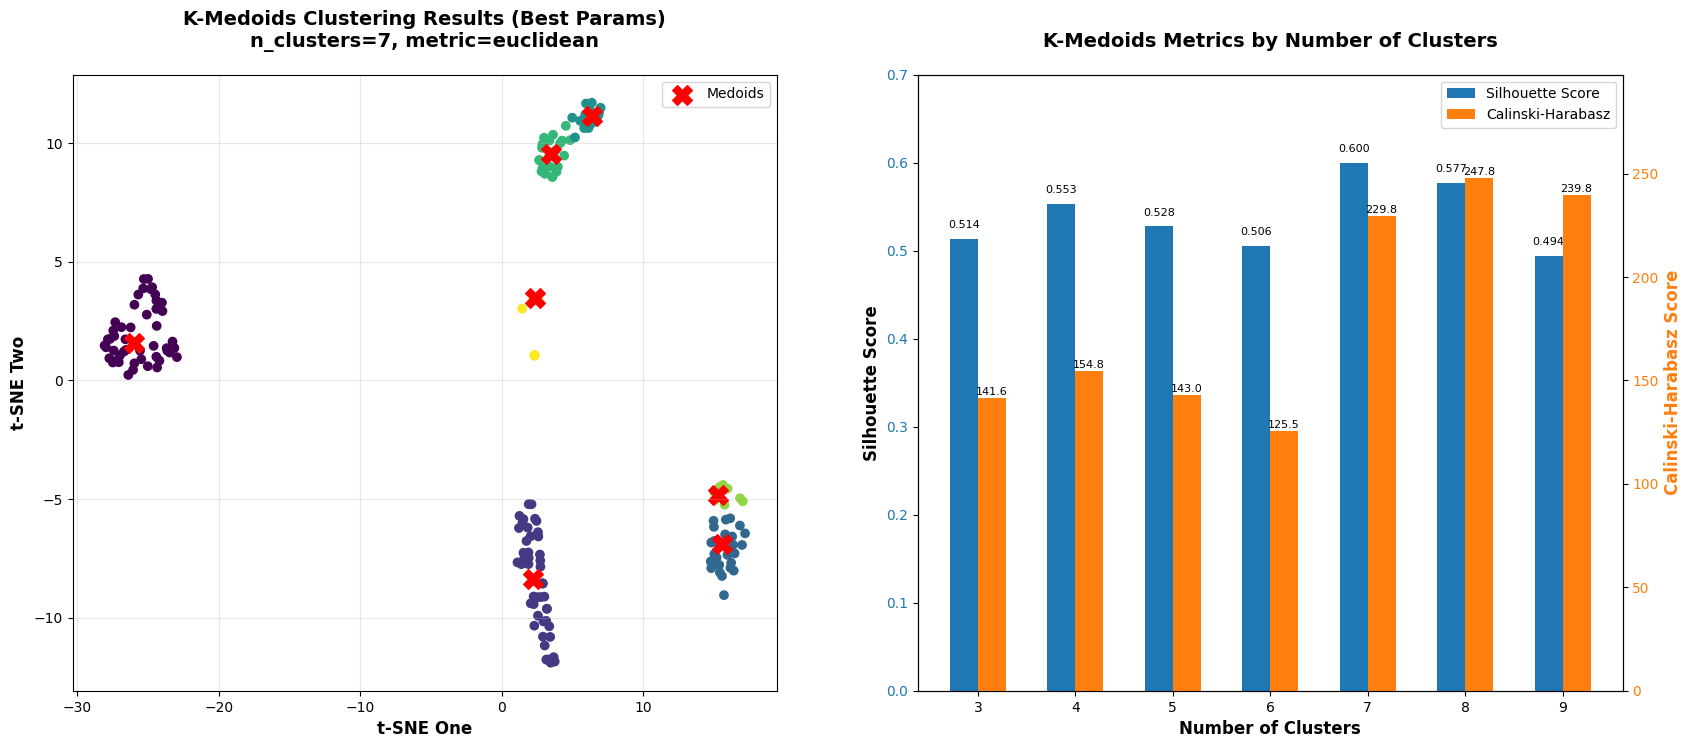

In [8]:
# 7.1 子图1：聚类散点图（按簇着色）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))  # 双图布局：散点图+指标对比


tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_kmedoids)
data_vis = pd.DataFrame({
    'tsne-one': tsne_result[:,0],
    'tsne-two': tsne_result[:,1],
    'Cluster': best_param['labels']
})

# 绘制样本点（按簇着色）
scatter = ax1.scatter(data_vis['tsne-one'], data_vis['tsne-two'], c=best_param['labels'])
# 标记质心（红色X，突出显示）
ax1.scatter(data_vis['tsne-one'][best_param['medoids']], data_vis['tsne-two'][best_param['medoids']], c='red', marker='X', s=200, label='Medoids')
# 图表样式（与原文一致）
ax1.set_xlabel('t-SNE One', fontsize=12, fontweight='bold')
ax1.set_ylabel('t-SNE Two', fontsize=12, fontweight='bold')
ax1.set_title(f'K-Medoids Clustering Results (Best Params)\nn_clusters={best_param["n_clusters"]}, metric={best_param["metric"]}', 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 7.2 子图2：不同簇数的指标对比（辅助业务决策）
cluster_metrics = results_df.groupby('n_clusters').agg(
    {'silhouette_score': 'max','calinski_harabasz_score': 'max'}
).reset_index()

# 双轴图：左轴=轮廓系数，右轴=Calinski-Harabasz
ax2_twin = ax2.twinx()
width = 0.8;     gap = 1.2
x_coords = np.arange(len(cluster_metrics['n_clusters'])) * (width * 2 + gap)
bar1 = ax2.bar(
    x_coords - width / 2, cluster_metrics['silhouette_score'],
    width=width, label='Silhouette Score', color='#1f77b4'
)
bar2 = ax2_twin.bar(
    x_coords + width / 2, cluster_metrics['calinski_harabasz_score'],  # 缩放以便同图显示
    width=width, label='Calinski-Harabasz', color='#ff7f0e'
)
# 图表样式
ax2.set_xlabel('Number of Clusters', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_ybound(0, cluster_metrics['silhouette_score'].max() + 0.1)  # 自动设置y轴上限
ax2_twin.set_ylabel('Calinski-Harabasz Score', fontsize=12, fontweight='bold', color='#ff7f0e')
ax2_twin.set_ybound(0, cluster_metrics['calinski_harabasz_score'].max() + 50)  # 自动设置y轴上限
ax2.set_title('K-Medoids Metrics by Number of Clusters', fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x_coords)
ax2.set_xticklabels(cluster_metrics['n_clusters'])
ax2.tick_params(axis='y', labelcolor='#1f77b4')
ax2_twin.tick_params(axis='y', labelcolor='#ff7f0e')
# 添加数值标签
for bar in bar1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)
for bar in bar2:
    height = bar.get_height()
    ax2_twin.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                  f'{height:.1f}', ha='center', va='bottom', fontsize=8)
# 合并图例
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='upper right')

display(cluster_metrics)

# # 8. 保存结果（可选：保存最优参数的聚类标签到原数据集）
# data_kmedoids['kmedoids_cluster_best'] = best_param['labels']  # 新增最优聚类标签列
# data_kmedoids.to_csv('KMedoids_Best_Clustering_Result.csv', index=False)  # 保存结果到CSV
# plt.tight_layout()
# plt.savefig('KMedoids_Hyperparameter_Tuning_Result.png', dpi=300, bbox_inches='tight')  # 保存可视化图
# plt.show()

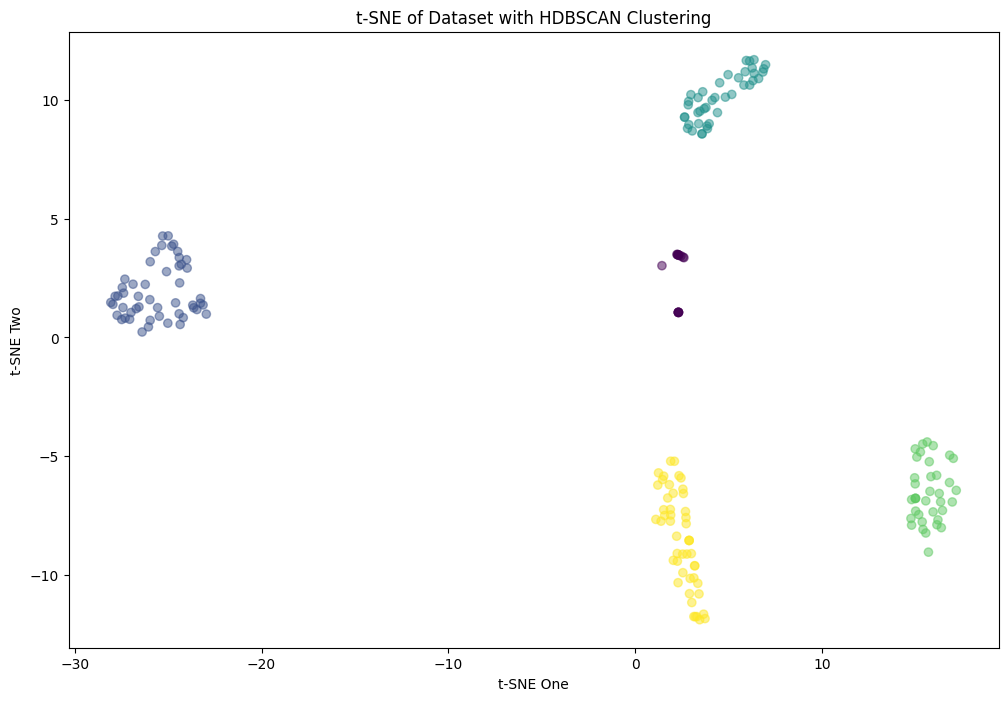

In [9]:
# 初次HDBSCAN聚类
from sklearn.cluster import HDBSCAN
# import tSNE
from sklearn.manifold import TSNE
hdbscan_model = HDBSCAN(min_cluster_size=10)
data_hdbscan = df.copy() # already preprocessed
data_hdbscan_safety = data_hdbscan.copy()
hdbscan_results = hdbscan_model.fit_predict(data_hdbscan)

# apply clustering algorithm
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result_hdbscan = tsne.fit_transform(data_hdbscan)
# data_hdbscan['tsne-one'] = tsne_result_hdbscan[:,0]
# data_hdbscan['tsne-two'] = tsne_result_hdbscan[:,1]
data_hdbscan_vis = pd.DataFrame({
    'tsne-one': tsne_result_hdbscan[:,0],
    'tsne-two': tsne_result_hdbscan[:,1],
    'cluster': hdbscan_results
})

def evaluate_noise(predicted_labels, data):
    n_clusters = len(set(predicted_labels) - {-1})
    noise_ratio = np.sum(predicted_labels == -1) / len(predicted_labels)
    return n_clusters, noise_ratio

plt.figure(figsize=(12,8))
plt.scatter(data_hdbscan_vis['tsne-one'], data_hdbscan_vis['tsne-two'], alpha=0.5, c=data_hdbscan_vis['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE of Dataset with HDBSCAN Clustering')
plt.show()

In [10]:
# 4. HDBSCAN超参网格搜索（核心：遍历关键参数组合）
param_grid = {
    'min_cluster_size': [10, 15, 20, 25],  # 最小簇规模（重点调整）
    'min_samples': [5, 10, 15],            # 核心点邻域样本数
    'cluster_selection_epsilon': [1.0, 1.5, 2.0],  # 簇距离阈值
    'cluster_selection_method': ['eom'],   # 簇选择策略（默认eom更稳定）
    'metric': ['euclidean', 'manhattan']   # 距离度量
}

# 存储所有参数组合的结果
search_results = []

# 遍历参数网格
for min_cluster in param_grid['min_cluster_size']:
    for min_samp in param_grid['min_samples']:
        # 确保min_samples ≤ min_cluster_size（逻辑合理）
        if min_samp > min_cluster:
            continue
        for eps in param_grid['cluster_selection_epsilon']:
            for method in param_grid['cluster_selection_method']:
                for metric in param_grid['metric']:
                    # 初始化HDBSCAN模型
                    hdbscan_model = HDBSCAN(
                        min_cluster_size=min_cluster,
                        min_samples=min_samp,
                        cluster_selection_epsilon=eps,
                        cluster_selection_method=method,
                        metric=metric
                    )
                    # 基于原始高维数据聚类（核心：不依赖降维）
                    cluster_labels = hdbscan_model.fit_predict(data_hdbscan.values)
                    # 评估聚类效果
                    sil_score, chs_score = evaluate_clustering(cluster_labels, data_hdbscan.values)
                    n_clusters, noise_ratio = evaluate_noise(cluster_labels, data_hdbscan.values)
                    # 存储结果
                    search_results.append({
                        'min_cluster_size': min_cluster,
                        'min_samples': min_samp,
                        'cluster_selection_epsilon': eps,
                        'cluster_selection_method': method,
                        'metric': metric,
                        'silhouette_score': sil_score,
                        'calinski_harabasz_score': chs_score,
                        'n_clusters': n_clusters,
                        'noise_ratio': noise_ratio,
                        'cluster_labels': cluster_labels
                    })

# 转换为DataFrame便于查看
results_df = pd.DataFrame(search_results)
# 筛选有效结果（排除无有效簇的情况）
valid_results = results_df[results_df['n_clusters'] > 1].copy()
# valid_results

In [11]:
# 5. 选择最优超参数（优先轮廓系数最高）
# 按轮廓系数降序排列，取前5个候选
top_candidates = valid_results.sort_values('silhouette_score', ascending=False).head(10)
best_candidate = top_candidates.iloc[0]
# # 打印最优参数信息
print("=== HDBSCAN最优超参数组合 ===")
print(f"最小簇规模 (min_cluster_size): {best_candidate['min_cluster_size']}")
print(f"核心点邻域样本数 (min_samples): {best_candidate['min_samples']}")
print(f"簇距离阈值 (cluster_selection_epsilon): {best_candidate['cluster_selection_epsilon']}")
print(f"簇选择策略 (cluster_selection_method): {best_candidate['cluster_selection_method']}")
print(f"距离度量 (metric): {best_candidate['metric']}")
print(f"\n聚类评估指标:")
print(f"轮廓系数: {best_candidate['silhouette_score']:.4f}")
print(f"Calinski-Harabasz指数: {best_candidate['calinski_harabasz_score']:.2f}")
print(f"有效簇数: {best_candidate['n_clusters']}")
print(f"噪声占比: {best_candidate['noise_ratio']:.2%}")

=== HDBSCAN最优超参数组合 ===
最小簇规模 (min_cluster_size): 15
核心点邻域样本数 (min_samples): 15
簇距离阈值 (cluster_selection_epsilon): 2.0
簇选择策略 (cluster_selection_method): eom
距离度量 (metric): manhattan

聚类评估指标:
轮廓系数: 0.6506
Calinski-Harabasz指数: 333.34
有效簇数: 4
噪声占比: 11.92%


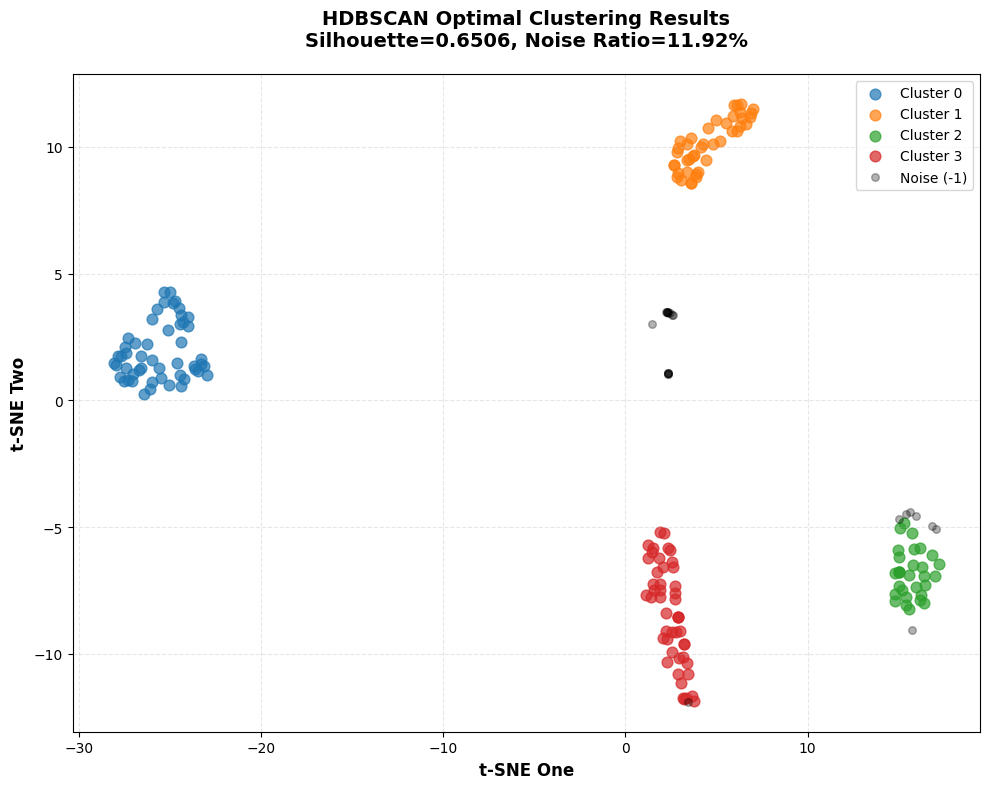

In [12]:
# 6. 最优结果可视化（原始数据聚类 + t-SNE降维展示）
# t-SNE降维（仅用于可视化，不影响聚类结果）
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(data_hdbscan.values)

# 构建可视化数据（合并t-SNE坐标与最优标签）
vis_df = pd.DataFrame({
    't-SNE One': tsne_result[:, 0],
    't-SNE Two': tsne_result[:, 1],
    'Cluster': best_candidate['cluster_labels']
})

# 绘制聚类散点图（噪声点用黑色标记）
plt.figure(figsize=(10, 8))
# 绘制有效簇（排除噪声）
for cluster in set(vis_df['Cluster']) - {-1}:
    mask = vis_df['Cluster'] == cluster
    plt.scatter(
        vis_df.loc[mask, 't-SNE One'],
        vis_df.loc[mask, 't-SNE Two'],
        alpha=0.7,
        s=60,
        label=f'Cluster {cluster}'
    )
# 绘制噪声点（黑色，透明度降低）
noise_mask = vis_df['Cluster'] == -1
plt.scatter(
    vis_df.loc[noise_mask, 't-SNE One'],
    vis_df.loc[noise_mask, 't-SNE Two'],
    c='black',
    alpha=0.3,
    s=30,
    label='Noise (-1)'
)

# 图表样式
plt.xlabel('t-SNE One', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Two', fontsize=12, fontweight='bold')
plt.title(
    f'HDBSCAN Optimal Clustering Results\nSilhouette={best_candidate["silhouette_score"]:.4f}, Noise Ratio={best_candidate["noise_ratio"]:.2%}',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [13]:
# 假设已生成tsne_result（t-SNE降维结果）和df_scaled（标准化后的原始特征）
# 1. 构建t-SNE维度与原始特征的关联数据集
hdbs_tsne_features = pd.DataFrame(tsne_result, columns=['t-SNE One', 't-SNE Two'])
# 合并原始标准化特征
hdbscan_corr_df = pd.concat([data_hdbscan.reset_index(drop=True), hdbs_tsne_features.reset_index(drop=True)], axis=1)
# 2. 计算原始特征与t-SNE维度的皮尔逊相关系数（核心：量化特征贡献）
hdb_correlation_matrix = hdbscan_corr_df.corr()[['t-SNE One', 't-SNE Two']].round(3)
print("=== 原始特征与t-SNE维度的相关系数 ===")
display(hdb_correlation_matrix)

# 示例解读：若"Annual Income (k$)"与t-SNE_1的相关系数为0.8，说明t-SNE_1主要反映年收入的差异

=== 原始特征与t-SNE维度的相关系数 ===


,t-SNE One,t-SNE Two
Age Annual Income (k$),0.695,-0.308
AgeGroup_61-69,0.083,0.129
Annual Income (k$),0.875,-0.558
IncomeBin_Q1,-0.937,0.210
IncomeBin_Q2,0.242,0.781
IncomeBin_Q3,0.184,-0.614
Income_per_Age,0.650,-0.494
t-SNE One,1.000,-0.267
t-SNE Two,-0.267,1.000


**since HDBSCAN best distinguishes the data points into two clusters, we apply HDBSCAN to distinguish the High consumption group (cluster 1) from the Low consumption group (cluster 0).**


In [14]:
# BIC analysis: determine the best interval of n_components for GMM
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
data_for_BIC = df.copy()
X_for_BIC = data_for_BIC.copy()
# tsne_res_for_BIC = tsne.fit_transform(data_for_BIC)
# data_for_BIC['tsne-one'] = tsne_res_for_BIC[:,0]
# data_for_BIC['tsne-two'] = tsne_res_for_BIC[:,1]
# X_for_BIC = data_for_BIC[['tsne-one', 'tsne-two']].values

# 2.1 超参设置：固定其他超参为合理默认值，仅遍历n_components
fixed_cov_type = 'full'  # 先固定为默认全协方差（后续再扩展分析）
fixed_max_iter = 500     # 确保收敛的迭代次数
fixed_tol = 1e-3         # 默认收敛阈值
n_components_range = range(2, 11)  # 初步遍历2-10个聚类（覆盖业务常用范围）

bic_results_ncomp = []
for n_comp in n_components_range:
    gmm = GaussianMixture(
        n_components=n_comp,
        covariance_type=fixed_cov_type,
        max_iter=fixed_max_iter,
        tol=fixed_tol,
        random_state=42,
        init_params='kmeans'
    )
    gmm.fit(X_for_BIC)  # 拟合模型（BIC需基于拟合结果计算）
    bic_score = gmm.bic(X_for_BIC)  # 计算当前超参的BIC值
    bic_results_ncomp.append({
        'n_components': n_comp,
        'covariance_type': fixed_cov_type,
        'bic_score': bic_score
    })
# 转换为DataFrame便于处理
bic_df_ncomp = pd.DataFrame(bic_results_ncomp)
# 找出BIC最小的n_components（最优值）和对应的区间（±1范围，确保后续网格搜索覆盖）
best_ncomp = bic_df_ncomp.loc[bic_df_ncomp['bic_score'].idxmin(), 'n_components']
best_ncomp_range = [max(2, best_ncomp - 2), min(10, best_ncomp + 2)]  # 锁定最优区间（避免超出范围）
print(f"=== BIC分析结果(固定cov_type={fixed_cov_type})===")
print(f"BIC最小对应的最优n_components:{int(best_ncomp)}")
print(f"后续网格搜索建议n_components区间:{best_ncomp_range[0]}~{best_ncomp_range[1]}\n")
display(bic_df_ncomp)

=== BIC分析结果(固定cov_type=full)===
BIC最小对应的最优n_components:7
后续网格搜索建议n_components区间:5~9



,n_components,covariance_type,bic_score
0,2,full,-2472.592220
1,3,full,-3847.896903
2,4,full,-5469.138837
3,5,full,-5364.148250
4,6,full,-7140.840646
5,7,full,-7252.742679
6,8,full,-7206.201860
7,9,full,-7061.243389
8,10,full,-7001.785730


In [15]:
# BIC extension-- evaluate the effect of covariance_type
cov_types = ['full', 'tied', 'diag', 'spherical']
bic_results_cov = []
for cov_type in cov_types:
    for n_comp in n_components_range:
        gmm = GaussianMixture(
            n_components=n_comp,
            covariance_type=cov_type,
            max_iter=fixed_max_iter,
            tol=fixed_tol,
            random_state=42
        )
        gmm.fit(X_for_BIC)
        bic_score = gmm.bic(X_for_BIC)
        bic_results_cov.append({
            'n_components': n_comp,
            'covariance_type': cov_type,
            'bic_score': bic_score
        })
bic_df_cov = pd.DataFrame(bic_results_cov)
# Find the best n_components under every type of covariance matrix（验证区间一致性）
best_ncomp_per_cov = bic_df_cov.groupby('covariance_type').apply(
    lambda x: x.loc[x['bic_score'].idxmin(), 'n_components']
).reset_index()
best_ncomp_per_cov.columns = ['covariance_type', 'best_n_components']
display(best_ncomp_per_cov)
print("经验证，不同类型协方差对应的最佳n_components表现出较高一致性。")

C:\Users\18469\AppData\Local\Temp\ipykernel_15272\2386341529.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_ncomp_per_cov = bic_df_cov.groupby('covariance_type').apply(


,covariance_type,best_n_components
0,diag,8
1,full,7
2,spherical,10
3,tied,8


经验证，不同类型协方差对应的最佳n_components表现出较高一致性。


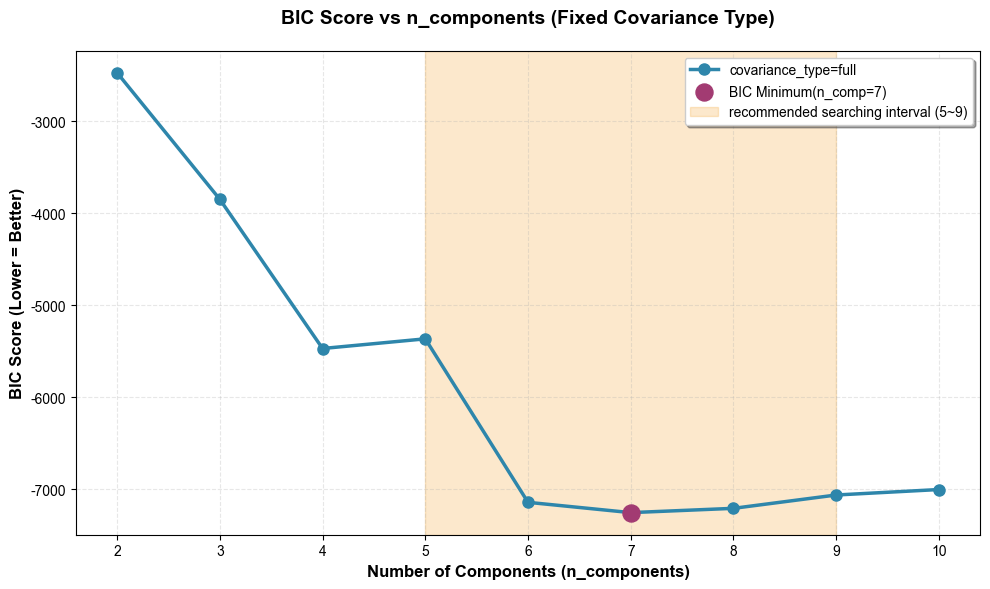

In [16]:
# BIC result visualization
plt.rcParams['font.sans-serif'] = ['Arial']  # 统一字体（避免乱码）
plt.rcParams['axes.unicode_minus'] = False

# 4.1 图1：固定cov_type下n_components与BIC的关系（核心区间分析）
plt.figure(figsize=(10, 6))
# 绘制BIC趋势线（带标记点）
plt.plot(
    bic_df_ncomp['n_components'], 
    bic_df_ncomp['bic_score'], 
    marker='o', 
    linewidth=2.5, 
    markersize=8, 
    color='#2E86AB', 
    label=f'covariance_type={fixed_cov_type}'
)
# 标记BIC最小值点
best_bic_score = bic_df_ncomp.loc[bic_df_ncomp['n_components'] == best_ncomp, 'bic_score'].values[0]
plt.scatter(
    best_ncomp, 
    best_bic_score, 
    color='#A23B72', 
    s=150, 
    zorder=5, 
    label=f'BIC Minimum(n_comp={int(best_ncomp)})'
)
# 标记最优区间（背景色高亮）
plt.axvspan(
    best_ncomp_range[0], 
    best_ncomp_range[1], 
    alpha=0.2, 
    color='#F18F01', 
    label=f'recommended searching interval ({best_ncomp_range[0]}~{best_ncomp_range[1]})'
)
# 图表美化
plt.xlabel('Number of Components (n_components)', fontsize=12, fontweight='bold')
plt.ylabel('BIC Score (Lower = Better)', fontsize=12, fontweight='bold')
plt.title('BIC Score vs n_components (Fixed Covariance Type)', fontsize=14, fontweight='bold', pad=20)
plt.xticks(n_components_range, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

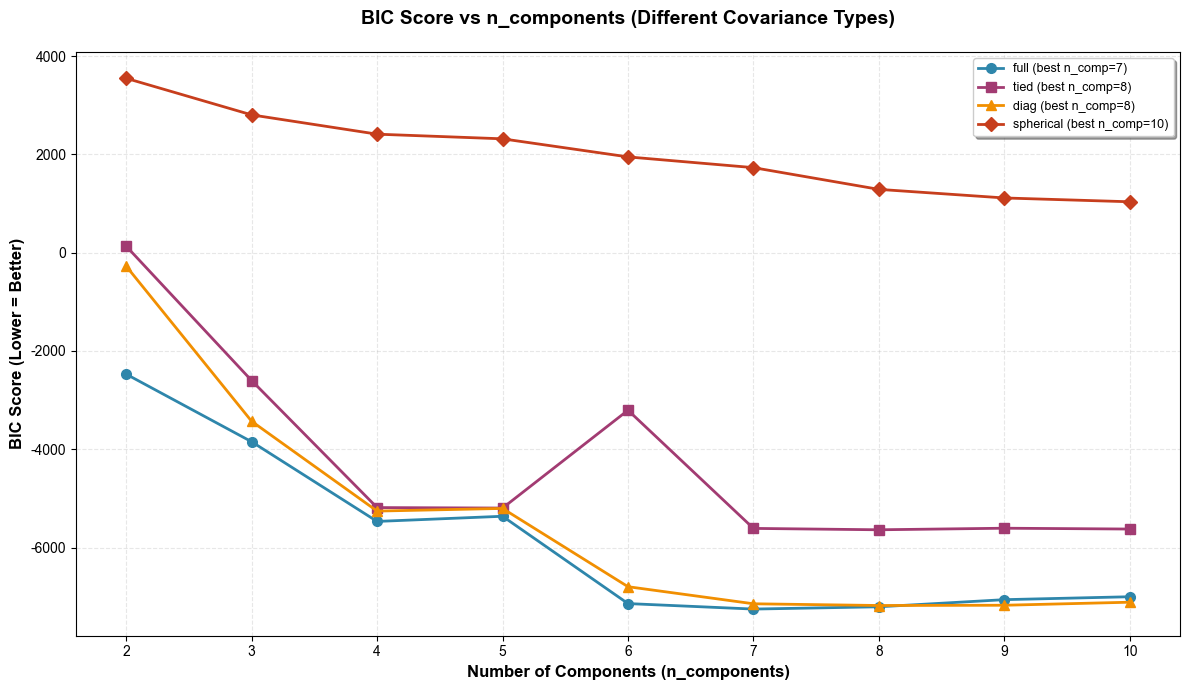

In [17]:
# 4.2 图2：不同cov_type下n_components与BIC的对比（扩展分析）
plt.figure(figsize=(12, 7))
# 为每种协方差类型设置不同颜色和标记
color_map = {'full': '#2E86AB', 'tied': '#A23B72', 'diag': '#F18F01', 'spherical': '#C73E1D'}
marker_map = {'full': 'o', 'tied': 's', 'diag': '^', 'spherical': 'D'}

for cov_type in cov_types:
    cov_data = bic_df_cov[bic_df_cov['covariance_type'] == cov_type]
    # 绘制每种协方差类型的BIC趋势
    plt.plot(
        cov_data['n_components'], 
        cov_data['bic_score'], 
        marker=marker_map[cov_type], 
        linewidth=2, 
        markersize=7, 
        color=color_map[cov_type], 
        label=f'{cov_type} (best n_comp={int(best_ncomp_per_cov[best_ncomp_per_cov["covariance_type"]==cov_type]["best_n_components"].values[0])})'
    )

# 图表美化
plt.xlabel('Number of Components (n_components)', fontsize=12, fontweight='bold')
plt.ylabel('BIC Score (Lower = Better)', fontsize=12, fontweight='bold')
plt.title('BIC Score vs n_components (Different Covariance Types)', fontsize=14, fontweight='bold', pad=20)
plt.xticks(n_components_range, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='upper right', fontsize=9, frameon=True, shadow=True, ncol=1)
plt.tight_layout()
plt.show()

In [18]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
data_gmm = df.copy() # already preprocessed
# apply clustering algorithm
# gmm = GaussianMixture(n_components=5, random_state=42)    for first trial only
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result_gmm = tsne.fit_transform(data_gmm)
# data_gmm['tsne-one'] = tsne_result_gmm[:,0]
# data_gmm['tsne-two'] = tsne_result_gmm[:,1]
# X_gmm = data_gmm[['tsne-one', 'tsne-two']].values
X_gmm = data_gmm.copy()

param_gmm = {
    'n_components': [6, 7, 8, 9, 10],  # 簇数搜索范围
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # 协方差类型
    'max_iter': [200, 500, 800],  # 最大迭代次数
    'tol': [1e-4, 1e-3, 1e-2],  # 收敛阈值
    'reg_covar': [1e-6, 1e-5, 1e-4]  # 正则化项
}

results_gmm = []
for n_comp in param_gmm['n_components']:
    for cov_type in param_gmm['covariance_type']:
        for max_it in param_gmm['max_iter']:
            for tol_val in param_gmm['tol']:
                for reg_covar in param_gmm['reg_covar']:
                # 初始化GMM模型
                    gmm = GaussianMixture(
                        n_components=n_comp,
                        covariance_type=cov_type,
                        max_iter=max_it,
                        tol=tol_val,
                        reg_covar=reg_covar,
                        random_state=42,
                        init_params='kmeans'  # 固定初始化方式（也可加入网格搜索）
                    )
                    
                    # 训练模型并预测聚类标签
                    cluster_labels = gmm.fit_predict(data_gmm)
                    
                    gmm_silhouette_score, gmm_chs = evaluate_clustering(cluster_labels, data_gmm)
                    
                    # 存储结果
                    results_gmm.append({
                        'n_components': n_comp,
                        'covariance_type': cov_type,
                        'max_iter': max_it,
                        'tol': tol_val,
                        'silhouette_score': gmm_silhouette_score,
                        'calinski_harabasz_score': gmm_chs
                    })

# 转换为DataFrame便于查看
results_df_gmm = pd.DataFrame(results_gmm)

# ---------------------- 筛选最优超参数（双指标最优） ----------------------
# 方法1：轮廓系数最高（优先聚类分离度）
gmm_best_silhouette_idx = results_df_gmm['silhouette_score'].idxmax()
gmm_best_params_silhouette = results_df_gmm.iloc[gmm_best_silhouette_idx]

# 方法2：Calinski-Harabasz分数最高（优先聚类紧致度）
gmm_best_chs_idx = results_df_gmm['calinski_harabasz_score'].idxmax()
gmm_best_params_chs = results_df_gmm.iloc[gmm_best_chs_idx]

# 打印最优结果
print("=== 最优超参数（轮廓系数最高）===")
print(f"超参数：n_components={gmm_best_params_silhouette['n_components']}, "
      f"covariance_type={gmm_best_params_silhouette['covariance_type']}, "
      f"max_iter={gmm_best_params_silhouette['max_iter']}, "
      f"tol={gmm_best_params_silhouette['tol']}")
print(f"轮廓系数：{gmm_best_params_silhouette['silhouette_score']:.4f}")
print(f"Calinski-Harabasz分数：{gmm_best_params_silhouette['calinski_harabasz_score']:.2f}\n")

print("=== 最优超参数（Calinski-Harabasz最高）===")
print(f"超参数：n_components={gmm_best_params_chs['n_components']}, "
      f"covariance_type={gmm_best_params_chs['covariance_type']}, "
      f"max_iter={gmm_best_params_chs['max_iter']}, "
      f"tol={gmm_best_params_chs['tol']}")
print(f"轮廓系数：{gmm_best_params_chs['silhouette_score']:.4f}")
print(f"Calinski-Harabasz分数：{gmm_best_params_chs['calinski_harabasz_score']:.2f}\n")

results_df_gmm

=== 最优超参数（轮廓系数最高）===
超参数：n_components=7, covariance_type=tied, max_iter=200, tol=0.0001
轮廓系数：0.6249
Calinski-Harabasz分数：230.42

=== 最优超参数（Calinski-Harabasz最高）===
超参数：n_components=10, covariance_type=spherical, max_iter=200, tol=0.01
轮廓系数：0.5048
Calinski-Harabasz分数：305.05



,n_components,covariance_type,max_iter,tol,silhouette_score,calinski_harabasz_score
0,6,full,200,0.0001,0.593265,223.688043
1,6,full,200,0.0001,0.593265,223.688043
2,6,full,200,0.0001,0.593265,223.688043
3,6,full,200,0.0010,0.593265,223.688043
4,6,full,200,0.0010,0.593265,223.688043
...,...,...,...,...,...,...
535,10,spherical,800,0.0010,0.502053,303.427801
536,10,spherical,800,0.0010,0.502053,303.427801
537,10,spherical,800,0.0100,0.504811,305.047569
538,10,spherical,800,0.0100,0.504811,305.047569


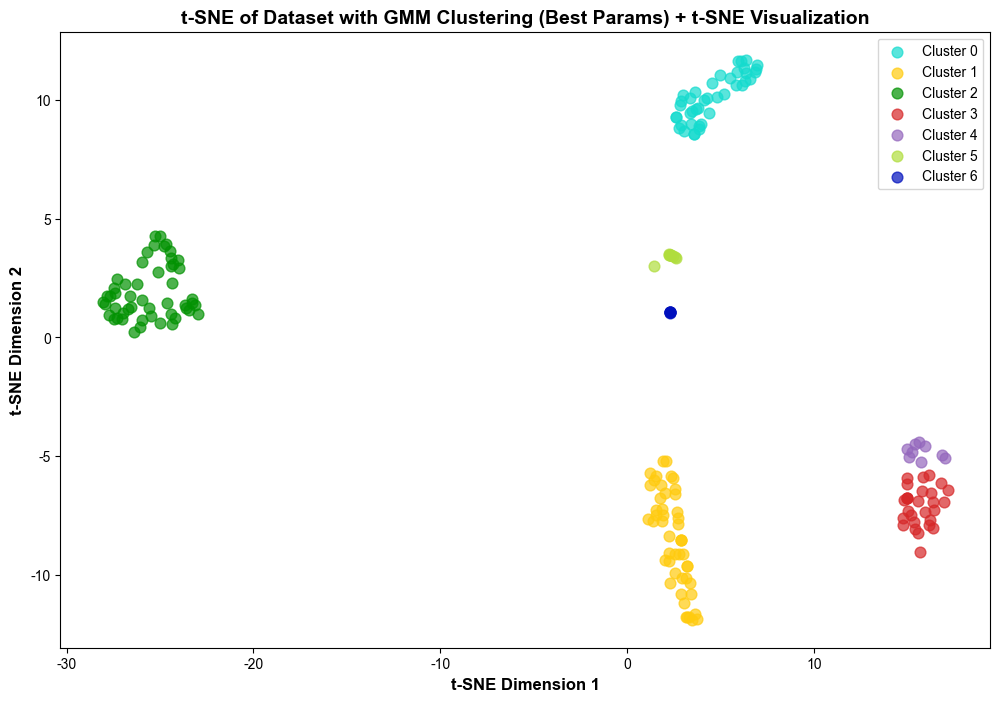

In [19]:
# 可视化最优超参组合的聚类结果
best_gmm = GaussianMixture(
    n_components=int(gmm_best_params_silhouette['n_components']),
    covariance_type=gmm_best_params_silhouette['covariance_type'],
    max_iter=int(gmm_best_params_silhouette['max_iter']),
    tol=gmm_best_params_silhouette['tol'],
    random_state=42,
    init_params='kmeans'
)
best_cluster_labels = best_gmm.fit_predict(data_gmm)
plt.figure(figsize=(12,8))

# t-SNE降维可视化
tsne = TSNE(n_components=2, random_state=42)
tsne_result_best_gmm = tsne.fit_transform(data_gmm)
data_gmm_vis = pd.DataFrame({
    'tsne-one': tsne_result_best_gmm[:,0],
    'tsne-two': tsne_result_best_gmm[:,1],
    'Cluster': best_cluster_labels
})
# 绘制样本点（按簇着色）
colors_gmm = ["#14dbce", "#ffcb0e", "#029202", '#d62728', '#9467bd', "#b0dd3d", "#0010BDF8", "#FF00B3", "#02ED02", "#FB6767", "#9C0F92"]  # 9簇配色，可扩展
for label in range(gmm_best_params_silhouette['n_components']):
    mask = data_gmm_vis['Cluster'] == label
    plt.scatter(
        data_gmm_vis.loc[mask, 'tsne-one'],
        data_gmm_vis.loc[mask, 'tsne-two'],
        c=colors_gmm[label],
        label=f'Cluster {label}',
        alpha=0.7,
        s=60
    )
plt.xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
plt.title('t-SNE of Dataset with GMM Clustering (Best Params) + t-SNE Visualization', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.show()

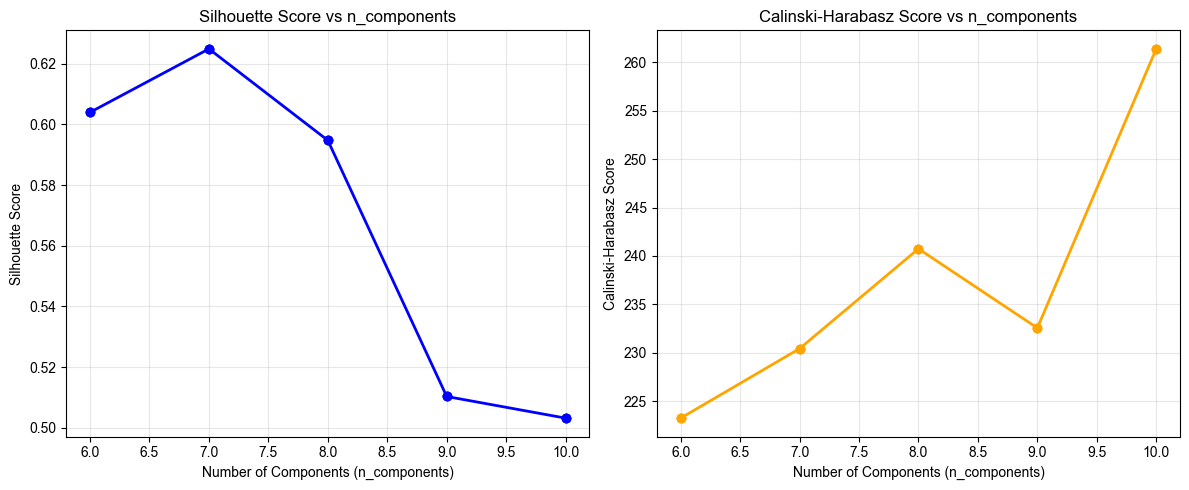

In [20]:
# 超参数对模型影响评估
# 1. n_components对评估指标的影响（固定其他最优超参）
best_cov = gmm_best_params_silhouette['covariance_type']
best_max_iter = gmm_best_params_silhouette['max_iter']
best_tol = gmm_best_params_silhouette['tol']

n_comp_results = results_df_gmm[
    (results_df_gmm['covariance_type'] == best_cov) &
    (results_df_gmm['max_iter'] == best_max_iter) &
    (results_df_gmm['tol'] == best_tol)
].sort_values('n_components')

plt.figure(figsize=(12, 5))

# 子图1：轮廓系数
plt.subplot(1, 2, 1)
plt.plot(n_comp_results['n_components'], n_comp_results['silhouette_score'], 'o-', color='blue', linewidth=2)
plt.xlabel('Number of Components (n_components)', fontsize=10)
plt.ylabel('Silhouette Score', fontsize=10)
plt.title('Silhouette Score vs n_components', fontsize=12)
plt.grid(alpha=0.3)

# 子图2：Calinski-Harabasz分数
plt.subplot(1, 2, 2)
plt.plot(n_comp_results['n_components'], n_comp_results['calinski_harabasz_score'], 'o-', color='orange', linewidth=2)
plt.xlabel('Number of Components (n_components)', fontsize=10)
plt.ylabel('Calinski-Harabasz Score', fontsize=10)
plt.title('Calinski-Harabasz Score vs n_components', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

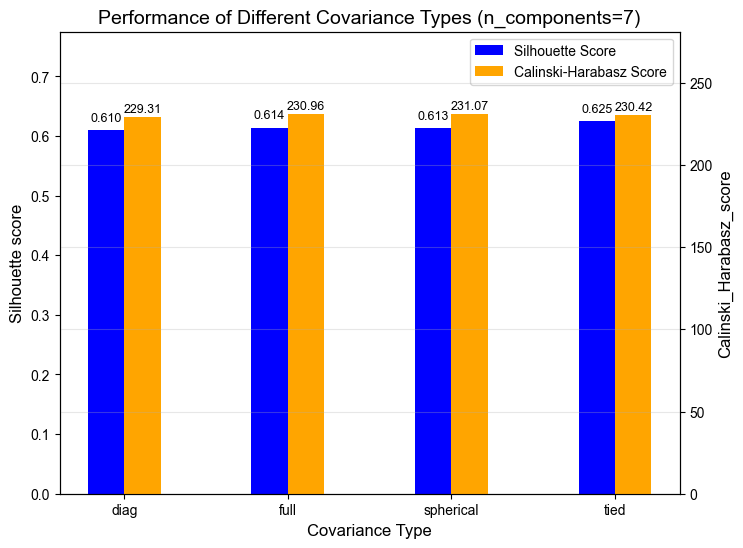

In [21]:
# 2. 不同covariance_type的性能对比（固定n_components为最优值）
n_comp_best = gmm_best_params_silhouette['n_components']
cov_results = results_df_gmm[
    (results_df_gmm['n_components'] == n_comp_best) &
    (results_df_gmm['max_iter'] == best_max_iter) &
    (results_df_gmm['tol'] == best_tol)
].groupby('covariance_type').agg({
    'silhouette_score': 'mean',
    'calinski_harabasz_score': 'mean'
}).reset_index()

# plt.figure(figsize=(10, 6))
fig, ax_gmm = plt.subplots(figsize=(8, 6))
ax_gmm_twin = ax_gmm.twinx()
width = 0.4; gap = 1.0
x = np.arange(len(cov_results['covariance_type'])) * (width*2 + gap)

# 归一化分数（便于同图展示）
# silhouette_norm = cov_results['silhouette_score'] / cov_results['silhouette_score'].max()
# chs_norm = cov_results['calinski_harabasz_score'] / cov_results['calinski_harabasz_score'].max()

# sil_bar = plt.bar(x - width/2, silhouette_norm, width, label='Normalized Silhouette Score', color='blue', alpha=0.7)
# chs_bar = plt.bar(x + width/2, chs_norm, width, label='Normalized Calinski-Harabasz Score', color='orange', alpha=0.7)
sil_bar = ax_gmm.bar(
    x - width/2, cov_results['silhouette_score'], 
    width, label='Silhouette Score', color='blue'
)
chs_bar = ax_gmm_twin.bar(
    x + width/2, cov_results['calinski_harabasz_score'], 
    width, label='Calinski-Harabasz Score', color='orange'
)
ax_gmm.set_xlabel('Covariance Type', fontsize=12)
ax_gmm.set_ylabel('Silhouette score', fontsize=12)
ax_gmm_twin.set_ylabel('Calinski_Harabasz_score', fontsize=12)
ax_gmm.set_title(f'Performance of Different Covariance Types (n_components={n_comp_best})', fontsize=14)
ax_gmm.set_xticks(x)
ax_gmm.set_xticklabels(cov_results['covariance_type'])
ax_gmm.set_ybound(upper=cov_results['silhouette_score'].max() + 0.15)
ax_gmm_twin.set_ybound(upper=cov_results['calinski_harabasz_score'].max() + 50)
for bar in sil_bar:
    h = bar.get_height()
    ax_gmm.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f'{h:.3f}', ha='center', va='bottom', fontsize=9)
    
for bar in chs_bar:
    h = bar.get_height()
    ax_gmm_twin.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                     f'{h:.2f}', ha='center', va='bottom', fontsize=9)

lines1, labels1 = ax_gmm.get_legend_handles_labels()
lines2, labels2 = ax_gmm_twin.get_legend_handles_labels()
ax_gmm.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='upper right')


# plt.xlabel('Covariance Type', fontsize=12)
# plt.ylabel('Normalized Score', fontsize=12)
# plt.title(f'Performance of Different Covariance Types (n_components={n_comp_best})', fontsize=14)
# plt.xticks(x, cov_results['covariance_type'])
# plt.legend()
# ax_gmm.legend(loc='upper right')
# ax_gmm_twin.legend(loc='upper left')
plt.grid(alpha=0.3, axis='y')
plt.show()

In [22]:
# 比较不同模型最优超参数下的聚类表现
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
kmedoids_best_params = {
    'n_clusters': 7,
    'max_iter': 500,
    'metric': 'euclidean'
}
gmm_best_params = {
    'n_clusters': 7,
    'covariance_type': 'tied',
    'max_iter': 200,
    'tol': .0001,
    'reg_covar' :1e-6
}
hdbscan_best_params = {
    'min_cluster_size': 15,
    'min_samples': 15,
    'cluster_selection_epsilon': 2.0,
    'cluster_selection_method': 'eom',
    'metric': 'manhattan'
}
# 5. 运行三种算法的最优超参聚类，获取标签
# 5.1 K-Medoids最优结果
kmedoids_medoids, kmedoids_labels = kmedoids_pam(
    X=X, n_clusters=kmedoids_best_params['n_clusters'], max_iter=kmedoids_best_params['max_iter'],
    metric='euclidean', random_state=42
)
# 5.2 GMM最优结果
gmm_best = GaussianMixture(
    n_components=gmm_best_params['n_clusters'], covariance_type=gmm_best_params['covariance_type'], max_iter=gmm_best_params['max_iter'], 
    tol=gmm_best_params['tol'], reg_covar=gmm_best_params['reg_covar'], random_state=42, init_params='kmeans'
)
gmm_labels = gmm_best.fit_predict(X)
# 5.3 HDBSCAN最优结果（过滤噪声后用于DB指数计算）
hdbscan_best = HDBSCAN(
    min_cluster_size=hdbscan_best_params['min_cluster_size'],
    min_samples=hdbscan_best_params['min_samples'], cluster_selection_epsilon=hdbscan_best_params['cluster_selection_epsilon'],
    cluster_selection_method=hdbscan_best_params['cluster_selection_method'], metric=hdbscan_best_params['metric']
)
hdbscan_labels = hdbscan_best.fit_predict(X)
# HDBSCAN过滤噪声（DB指数不支持噪声标签-1）
hdbscan_non_noise_idx = hdbscan_labels != -1
hdbscan_labels_clean = hdbscan_labels[hdbscan_non_noise_idx]
X_hdbscan_clean = X[hdbscan_non_noise_idx]

def calculate_metrics(algorithm_name, labels, data, is_hdbscan=False, data_clean=None, labels_clean=None):
    """统一计算聚类指标，适配HDBSCAN噪声处理"""
    # 轮廓系数
    if is_hdbscan:
        silhouette = silhouette_score(data_clean, labels_clean)
    else:
        silhouette = silhouette_score(data, labels)
    # CHS指数
    if is_hdbscan:
        chs = calinski_harabasz_score(data_clean, labels_clean)
    else:
        chs = calinski_harabasz_score(data, labels)
    # DB指数（越低越好，需至少2个簇）
    if is_hdbscan:
        db_index = davies_bouldin_score(data_clean, labels_clean) if len(set(labels_clean)) >= 2 else np.inf
    else:
        db_index = davies_bouldin_score(data, labels) if len(set(labels)) >= 2 else np.inf
    
    return {
        'Method': algorithm_name,
        'Silhouette score': round(silhouette, 4),
        'Calinski-Harabasz score': round(chs, 2),
        'Davies-Bouldin index': round(db_index, 4)
    }

kmedoids_metrics = calculate_metrics('K-Medoids', kmedoids_labels, X)
gmm_metrics = calculate_metrics('GMM', gmm_labels, X)
hdbscan_metrics = calculate_metrics( 'HDBSCAN', hdbscan_labels, X, is_hdbscan=True, data_clean=X_hdbscan_clean, labels_clean=hdbscan_labels_clean)

metrics_df = pd.DataFrame([kmedoids_metrics, gmm_metrics, hdbscan_metrics])
display(metrics_df)

,Method,Silhouette score,Calinski-Harabasz score,Davies-Bouldin index
0,K-Medoids,0.6002,229.75,0.6240
1,GMM,0.6249,230.42,0.5754
2,HDBSCAN,0.6506,333.34,0.5714


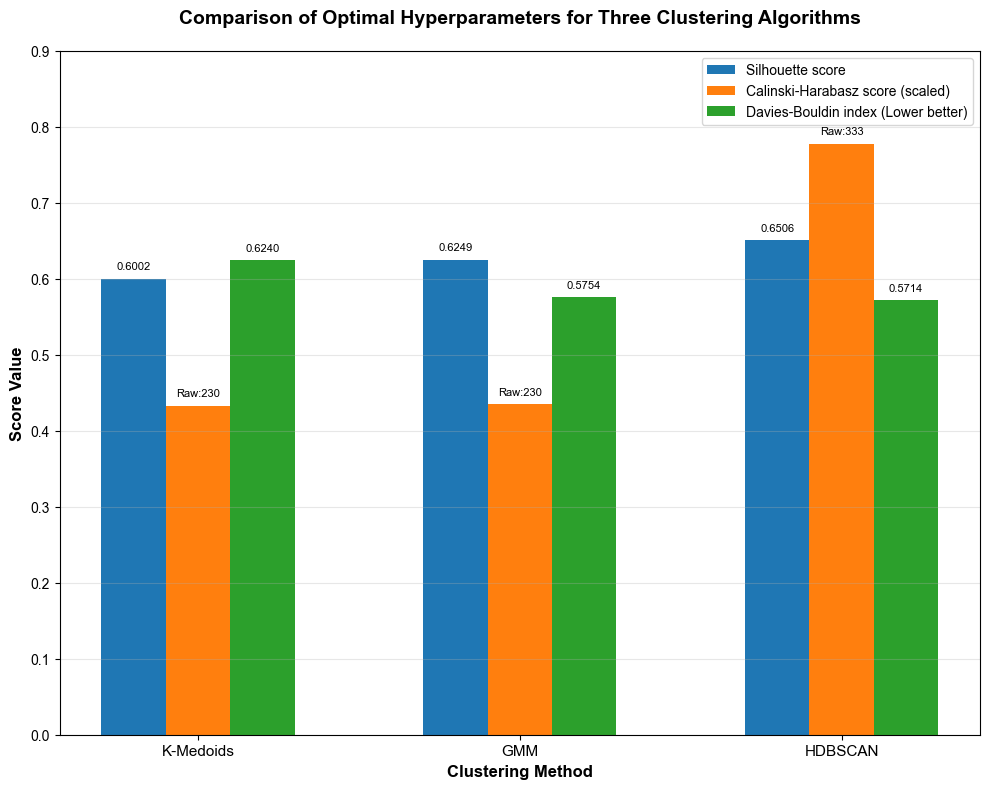

In [23]:
# 8. 可视化指标对比（柱状图）- 调整标准化与样式
# 仅对CHS指数做Z-Score标准化（替代Min-Max），Silhouette和DB用原始值
metrics_df_scaled = metrics_df.copy()
# Silhouette用原始值
metrics_df_scaled['silhouette_scaled'] = metrics_df_scaled['Silhouette score']
# CHS指数min-max标准化
chs_min=100
chs_max=400
metrics_df_scaled['CHS_scaled'] = (chs_min - metrics_df_scaled['Calinski-Harabasz score']) / (chs_min - chs_max)
# DB指数用原始值（注意DB越低越好，后续绘图时标注说明）
metrics_df_scaled['DB_scaled'] = metrics_df_scaled['Davies-Bouldin index']

# 绘制柱状图 - 调整width和gap，适配多指标展示
plt.figure(figsize=(10, 8))
x = np.arange(len(metrics_df_scaled['Method']))
width = 0.2  # 缩小柱子宽度，提升观感
gap = 1.0    # 簇间间隙

# 重新计算x坐标，避免重叠
x_sil = x - width
x_chs = x
x_db = x + width

# 绘制三个指标的柱状图（Silhouette和DB用原始值，CHS用Z-Score标准化）
plt.bar(x_sil, metrics_df_scaled['silhouette_scaled'], width, label='Silhouette score', color='#1f77b4')
plt.bar(x_chs, metrics_df_scaled['CHS_scaled'], width, label='Calinski-Harabasz score (scaled)', color='#ff7f0e')
plt.bar(x_db, metrics_df_scaled['DB_scaled'], width, label='Davies-Bouldin index (Lower better)', color='#2ca02c')

# 图表样式（全英文标注）
plt.xlabel('Clustering Method', fontsize=12, fontweight='bold')
plt.ylabel('Score Value', fontsize=12, fontweight='bold')
plt.title('Comparison of Optimal Hyperparameters for Three Clustering Algorithms', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, metrics_df_scaled['Method'], fontsize=11)
plt.ylim((0, 0.9))
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3, axis='y')

# 在柱子上添加原始数值标签
for i, (sil, chs, db) in enumerate(zip(
    metrics_df_scaled['Silhouette score'],
    metrics_df_scaled['Calinski-Harabasz score'],
    metrics_df_scaled['Davies-Bouldin index']
)):
    # Silhouette原始值标签
    plt.text(i - width, sil + 0.01, f'{sil:.4f}', ha='center', va='bottom', fontsize=8)
    # CHS原始值标签（标准化后柱子标注原始值）
    plt.text(i, metrics_df_scaled['CHS_scaled'].iloc[i] + 0.01, f'Raw:{chs:.0f}', ha='center', va='bottom', fontsize=8)
    # DB原始值标签
    plt.text(i + width, db + 0.01, f'{db:.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

- Considering comprehensively, we finally choose **HDBSCAN** as the final clustering model for its good performance.

In [75]:
clustering_results = pd.read_csv('HDBSCAN_clustered_data_age.csv')
clustering_results

,Age Annual Income (k$),AgeGroup_61-69,Annual Income (k$),IncomeBin_Q1,IncomeBin_Q2,IncomeBin_Q3,Income_per_Age,Cluster,Age
0,-1.699593,-0.290292,-1.866777,1.646675,-0.591312,-0.623289,-1.137799,0,21
1,-1.655382,-0.290292,-1.825592,1.646675,-0.591312,-0.623289,-1.158515,0,23
2,-1.522749,-0.290292,-1.784407,1.646675,-0.591312,-0.623289,-1.322240,0,31
3,-1.650377,-0.290292,-1.784407,1.646675,-0.591312,-0.623289,-1.072825,0,22
4,-1.436830,-0.290292,-1.743222,1.646675,-0.591312,-0.623289,-1.360152,0,35
...,...,...,...,...,...,...,...,...,...
188,1.148263,-0.290292,2.169371,-0.607284,-0.591312,-0.623289,1.875047,2,33
189,1.619569,-0.290292,2.169371,-0.607284,-0.591312,-0.623289,1.374131,2,38
190,2.742362,-0.290292,2.457667,-0.607284,-0.591312,-0.623289,0.906640,-1,47
191,1.541157,-0.290292,2.457667,-0.607284,-0.591312,-0.623289,1.879860,2,35


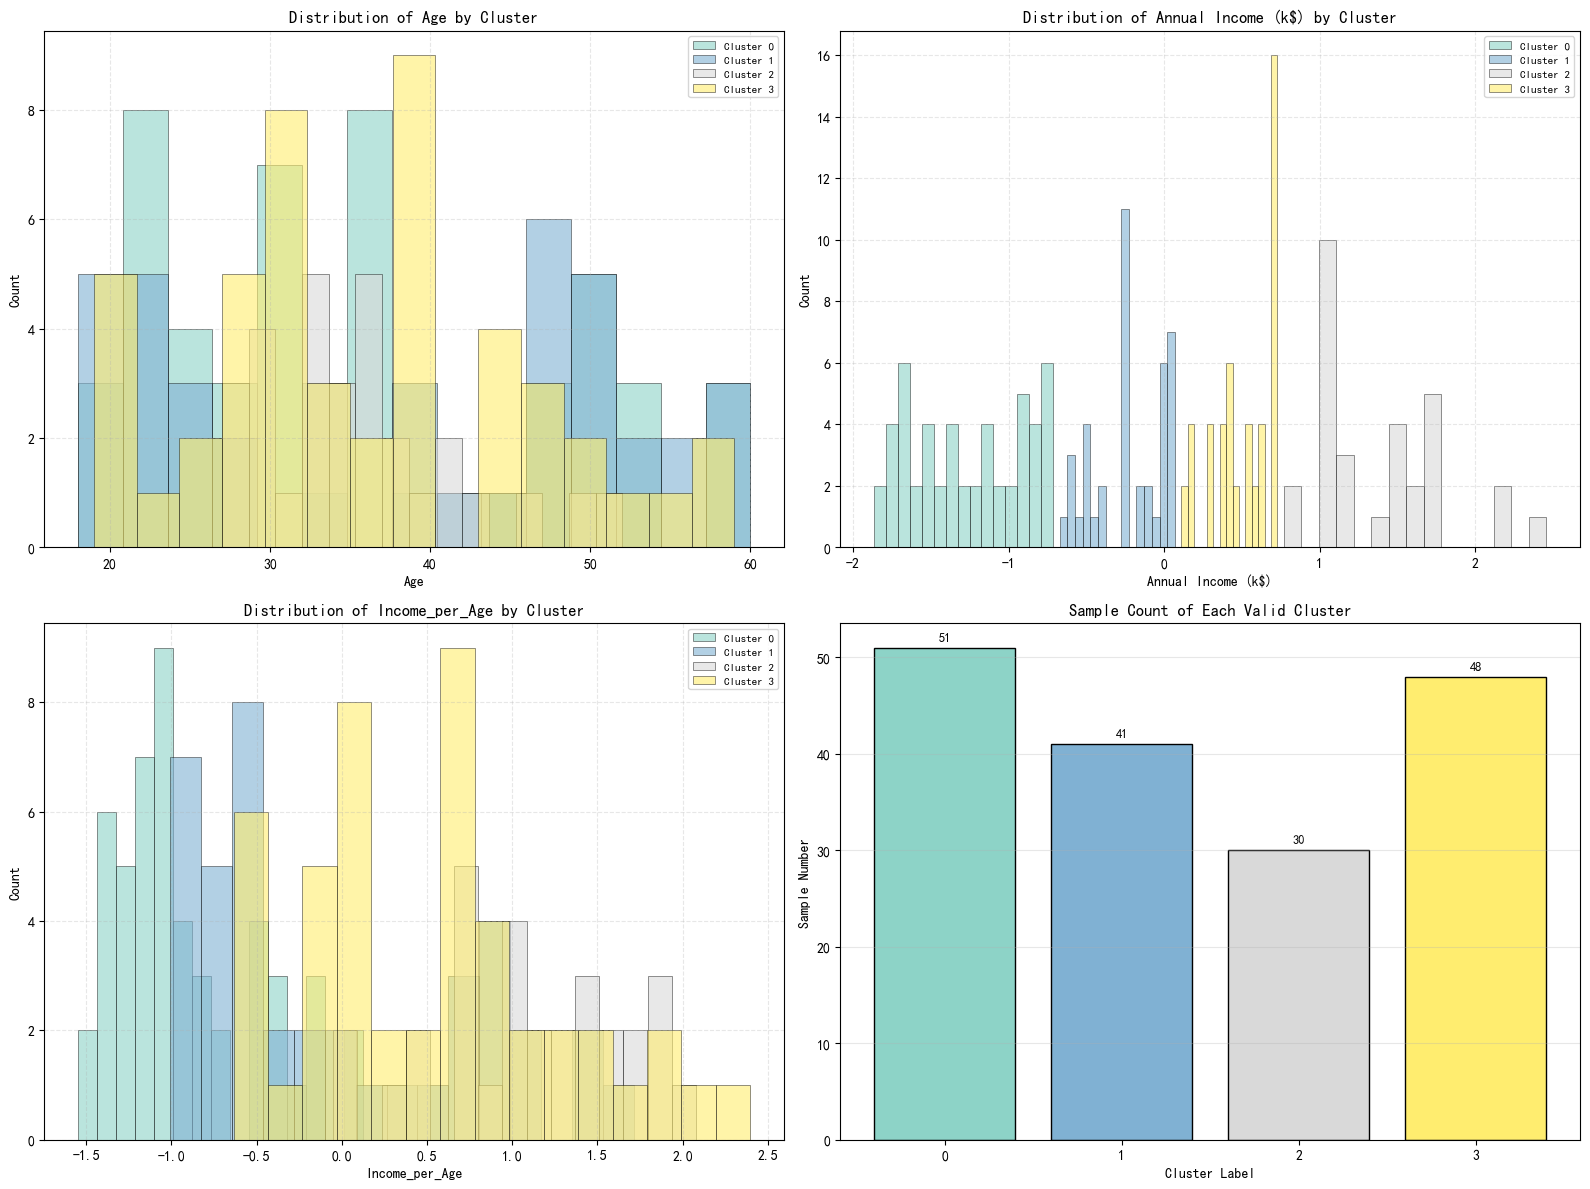

In [25]:
# In[25]: 聚类结果统计分析 - 核心维度分布直方图
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体（避免乱码）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 提取有效聚类标签（排除噪声标签-1）
valid_labels = sorted([label for label in clustering_results['Cluster'].unique() if label != -1])
n_clusters = len(valid_labels)
core_features = ['Age', 'Annual Income (k$)', 'Income_per_Age']  # 核心分析维度

# 创建2x2子图布局（3个核心维度+1个汇总统计）
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # 展平axes便于索引

# 定义颜色映射（每个聚类使用不同颜色）
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

# 1. 绘制每个核心维度的聚类分布直方图
for idx, feature in enumerate(core_features):
    ax = axes[idx]
    # 对每个有效聚类绘制直方图
    for label_idx, cluster_label in enumerate(valid_labels):
        cluster_data = clustering_results[clustering_results['Cluster'] == cluster_label][feature]
        ax.hist(cluster_data, alpha=0.6, bins=15, color=colors[label_idx], 
                label=f'Cluster {cluster_label}', edgecolor='black', linewidth=0.5)
    
    ax.set_title(f'Distribution of {feature} by Cluster', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3, linestyle='--')

# 2. 绘制各聚类样本数量统计（辅助分析群体规模）
cluster_counts = clustering_results[clustering_results['Cluster'] != -1]['Cluster'].value_counts().sort_index()
ax = axes[3]
bars = ax.bar(cluster_counts.index.astype(str), cluster_counts.values, color=colors, edgecolor='black')
ax.set_title('Sample Count of Each Valid Cluster', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster Label', fontsize=10)
ax.set_ylabel('Sample Number', fontsize=10)
# 在柱子上添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontsize=9)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

C:\Users\18469\AppData\Local\Temp\ipykernel_15272\3122526023.py:67: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\18469\AppData\Local\Temp\ipykernel_15272\3122526023.py:67: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\18469\AppData\Local\Temp\ipykernel_15272\3122526023.py:67: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\18469\AppData\Local\Temp\ipykernel_15272\3122526023.py:67: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


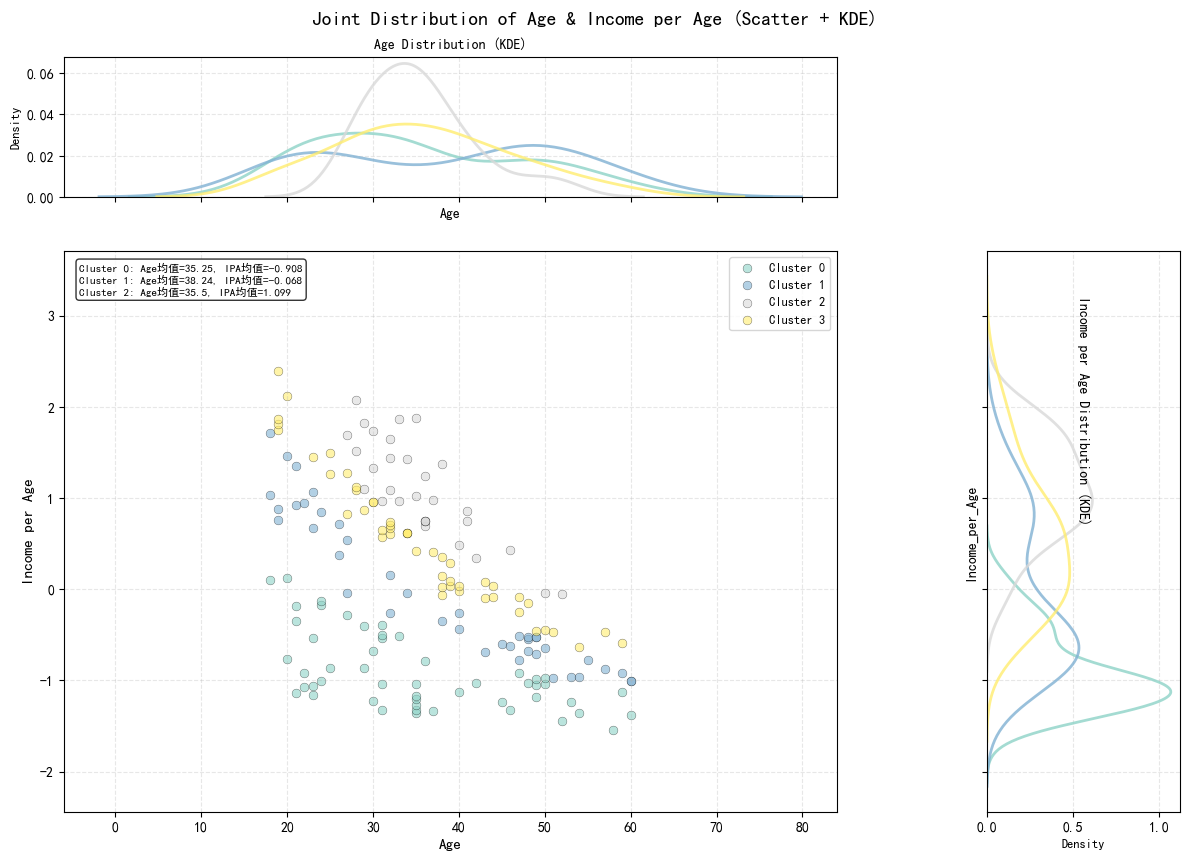

In [43]:
# In[26-27 合并]：Age & Income_per_Age 联合分布分析（散点+双维度KDE）
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# 设置中文字体（避免乱码）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 筛选有效数据（排除噪声聚类-1）
valid_data = clustering_results[clustering_results['Cluster'] != -1]
valid_labels = sorted(valid_data['Cluster'].unique())
n_clusters = len(valid_labels)
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))  # 聚类颜色映射

# 1. 构建联合图布局（中心+顶部+右侧）
fig = plt.figure(figsize=(12, 10))
# 使用gridspec划分区域：顶部占1行，中心+右侧占4行；中心占4列，右侧占1列
gs = gridspec.GridSpec(5, 5, height_ratios=[1, 4, 0, 0, 0], width_ratios=[4, 0, 0, 0, 1])

# 2. 创建子图对象
# 中心散点图（Age vs Income_per_Age）
ax_scatter = fig.add_subplot(gs[1, 0])
# 顶部KDE（Age维度）
ax_kde_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
# 右侧KDE（Income_per_Age维度，竖放）
ax_kde_y = fig.add_subplot(gs[1, 4], sharey=ax_scatter)

# 3. 绘制中心散点图（区分聚类）
for idx, cluster_label in enumerate(valid_labels):
    cluster_data = valid_data[valid_data['Cluster'] == cluster_label]
    ax_scatter.scatter(
        cluster_data['Age'],
        cluster_data['Income_per_Age'],
        color=colors[idx],
        label=f'Cluster {cluster_label}',
        alpha=0.6,
        s=40,
        edgecolor='black',
        linewidth=0.3
    )
ax_scatter.set_xlabel('Age', fontsize=11, fontweight='bold')
ax_scatter.set_ylabel('Income per Age', fontsize=11, fontweight='bold')
ax_scatter.grid(alpha=0.3, linestyle='--')
ax_scatter.legend(loc='upper right', fontsize=9, framealpha=0.8)

# 4. 绘制顶部KDE曲线（Age维度，多聚类叠加）
for idx, cluster_label in enumerate(valid_labels):
    cluster_data = valid_data[valid_data['Cluster'] == cluster_label]['Age']
    sns.kdeplot(
        cluster_data,
        ax=ax_kde_x,
        color=colors[idx],
        label=f'Cluster {cluster_label}',
        linewidth=2,
        alpha=0.8
    )
ax_kde_x.set_ylabel('Density', fontsize=9, fontweight='bold')
ax_kde_x.grid(alpha=0.3, linestyle='--')
ax_kde_x.set_title('Age Distribution (KDE)', fontsize=10, fontweight='bold')
# ax_kde_x.get_legend().remove()  # 复用中心图的图例，避免重复

# 5. 绘制右侧KDE曲线（Income_per_Age维度，竖放，多聚类叠加）
for idx, cluster_label in enumerate(valid_labels):
    cluster_data = valid_data[valid_data['Cluster'] == cluster_label]['Income_per_Age']
    sns.kdeplot(
        cluster_data,
        ax=ax_kde_y,
        color=colors[idx],
        vertical=True,  # 竖放KDE
        label=f'Cluster {cluster_label}',
        linewidth=2,
        alpha=0.8
    )
ax_kde_y.set_xlabel('Density', fontsize=9, fontweight='bold')
ax_kde_y.grid(alpha=0.3, linestyle='--')
ax_kde_y.set_title('Income per Age Distribution (KDE)', fontsize=10, fontweight='bold', rotation=270, x=0.5, y=0.5)
# ax_kde_y.get_legend().remove()  # 复用中心图的图例

# 6. 优化布局和样式
# 隐藏冗余的刻度标签（顶部KDE共享x轴，右侧KDE共享y轴）
plt.setp(ax_kde_x.get_xticklabels(), visible=False)
plt.setp(ax_kde_y.get_yticklabels(), visible=False)

# 调整子图间距
plt.subplots_adjust(hspace=0.1, wspace=0.05)
fig.suptitle('Joint Distribution of Age & Income per Age (Scatter + KDE)', fontsize=14, fontweight='bold', y=0.98)

# 7. 添加关键统计标注（中心图左上角）
# 计算各聚类核心统计量
stats_text = []
for cluster_label in valid_labels[:3]:  # 仅展示前3个聚类，避免标注过多
    cluster_data = valid_data[valid_data['Cluster'] == cluster_label]
    mean_age = cluster_data['Age'].mean().round(2)
    mean_ipa = cluster_data['Income_per_Age'].mean().round(3)
    stats_text.append(f'Cluster {cluster_label}: Age均值={mean_age}, IPA均值={mean_ipa}')
stats_text = '\n'.join(stats_text)

ax_scatter.text(
    0.02, 0.98,
    stats_text,
    transform=ax_scatter.transAxes,
    fontsize=8,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.show()

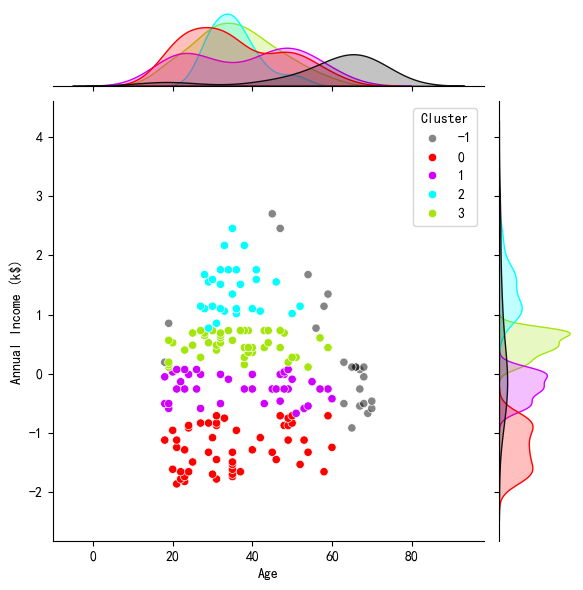

In [60]:
import seaborn as sns
color_map_ = {-1:"#11111182", 0:"#FF0000", 1:"#D000FF",2:"#00FFFF",3:"#A4E60C"}
sns.jointplot(data=clustering_results,x='Age',y='Annual Income (k$)',hue='Cluster',palette=color_map_)

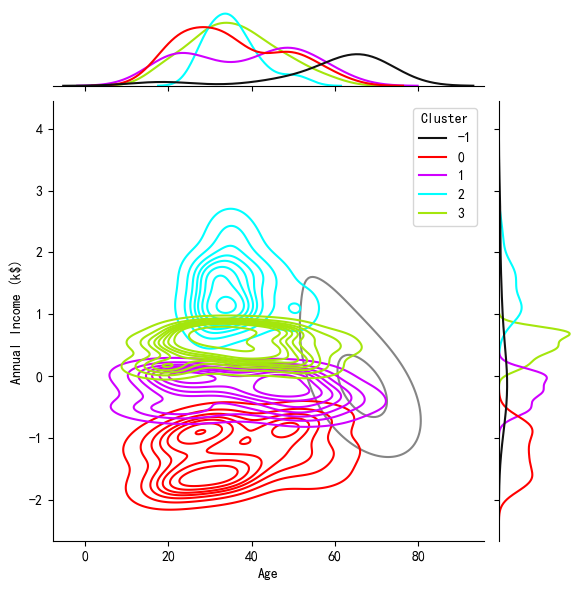

In [61]:
sns.jointplot(data=clustering_results,x='Age',y='Annual Income (k$)',hue='Cluster',palette=color_map_, kind='kde')

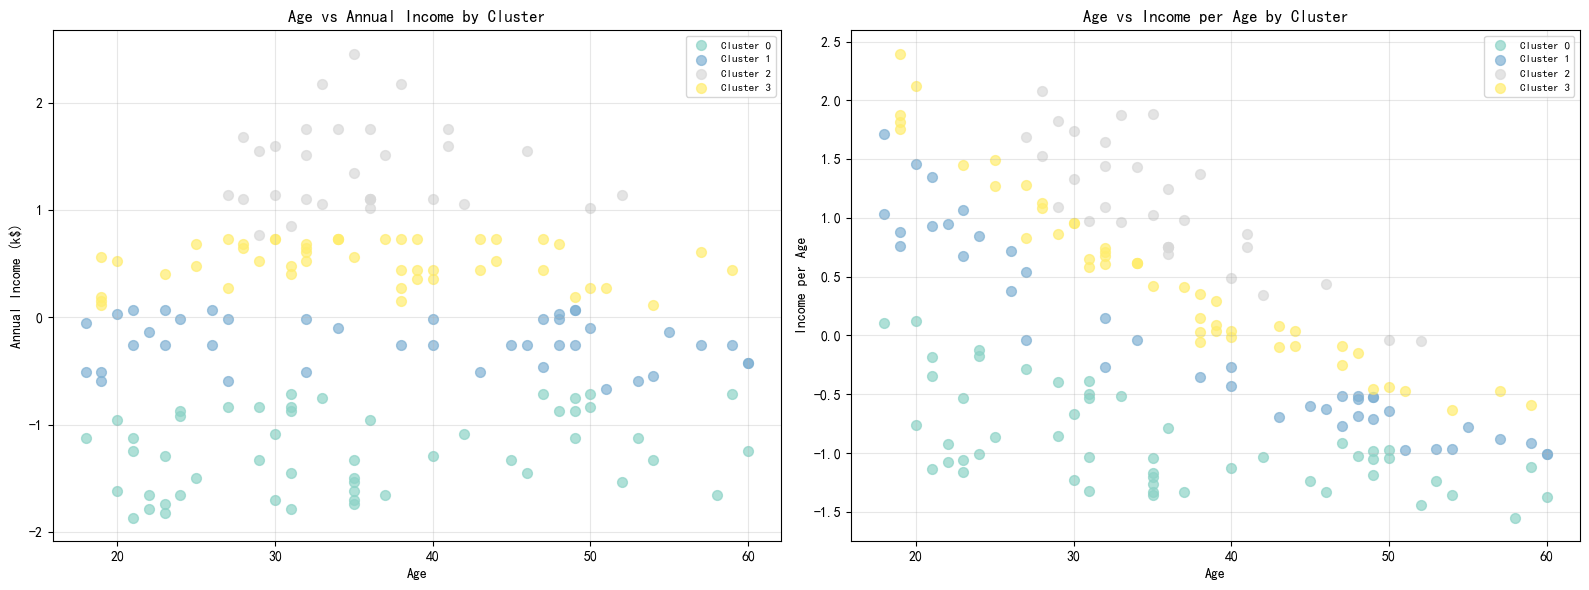

In [27]:
# In[28]: 聚类群体特征提炼 - 核心维度交叉分析（散点图矩阵）
# 选择两个关键维度进行交叉分析（年龄vs年收入，年龄vs收入年龄比）
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 年龄 vs 年收入
ax1 = axes[0]
for label_idx, cluster_label in enumerate(valid_labels):
    cluster_data = clustering_results[clustering_results['Cluster'] == cluster_label]
    ax1.scatter(cluster_data['Age'], cluster_data['Annual Income (k$)'], 
                c=[colors[label_idx]], label=f'Cluster {cluster_label}', alpha=0.7, s=50)
ax1.set_title('Age vs Annual Income by Cluster', fontsize=12, fontweight='bold')
ax1.set_xlabel('Age', fontsize=10)
ax1.set_ylabel('Annual Income (k$)', fontsize=10)
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3)

# 2. 年龄 vs 收入年龄比
ax2 = axes[1]
for label_idx, cluster_label in enumerate(valid_labels):
    cluster_data = clustering_results[clustering_results['Cluster'] == cluster_label]
    ax2.scatter(cluster_data['Age'], cluster_data['Income_per_Age'], 
                c=[colors[label_idx]], label=f'Cluster {cluster_label}', alpha=0.7, s=50)
ax2.set_title('Age vs Income per Age by Cluster', fontsize=12, fontweight='bold')
ax2.set_xlabel('Age', fontsize=10)
ax2.set_ylabel('Income per Age', fontsize=10)
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# # In[29]: 噪声样本与有效聚类的特征对比分析
# # 分离噪声样本和有效聚类样本
# noise_data = clustering_results[clustering_results['Cluster'] == -1]
# valid_data = clustering_results[clustering_results['Cluster'] != -1]
# display(noise_data)
# # 计算噪声样本和有效聚类的核心维度统计
# noise_stats = noise_data[core_features].agg(mean='mean', 中位数='median', 标准差='std').round(3)
# valid_stats = valid_data[core_features].agg(均值='mean', 中位数='median', 标准差='std').round(3)

# # 合并对比展示
# comparison_stats = pd.DataFrame({
#     '噪声样本（数量：{}）'.format(len(noise_data)): noise_stats.unstack(),
#     '有效聚类（数量：{}）'.format(len(valid_data)): valid_stats.unstack()
# })

# print("\n=== 噪声样本与有效聚类特征对比 ===")
# display(comparison_stats)

# # 可视化对比（雷达图）
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, polar=True)

# # 准备雷达图数据（标准化处理，便于对比）
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# # 提取均值数据并标准化
# noise_means = noise_data[core_features].mean().values.reshape(1, -1)
# valid_means = valid_data[core_features].mean().values.reshape(1, -1)
# scaled_noise = scaler.fit_transform(noise_means)[0]
# scaled_valid = scaler.fit_transform(valid_means)[0]

# # 设置雷达图角度
# angles = np.linspace(0, 2*np.pi, len(core_features), endpoint=False).tolist()
# angles += angles[:1]  # 闭合图形

# # 补充数据使图形闭合
# scaled_noise = np.append(scaled_noise, scaled_noise[0])
# scaled_valid = np.append(scaled_valid, scaled_valid[0])
# core_features_closed = core_features + [core_features[0]]

# # 绘制雷达图
# ax.plot(angles, scaled_noise, 'o-', linewidth=2, label='噪声样本', color='black', alpha=0.7)
# ax.fill(angles, scaled_noise, alpha=0.25, color='black')
# ax.plot(angles, scaled_valid, 'o-', linewidth=2, label='有效聚类', color='red', alpha=0.7)
# ax.fill(angles, scaled_valid, alpha=0.25, color='red')

# # 设置标签
# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(core_features, fontsize=10)
# ax.set_ylim(0, 1)
# ax.set_title('噪声样本与有效聚类核心特征标准化对比（雷达图）', fontsize=12, fontweight='bold', pad=20)
# ax.legend(loc='upper right', fontsize=10)
# ax.grid(True)

# plt.tight_layout()
# plt.show()

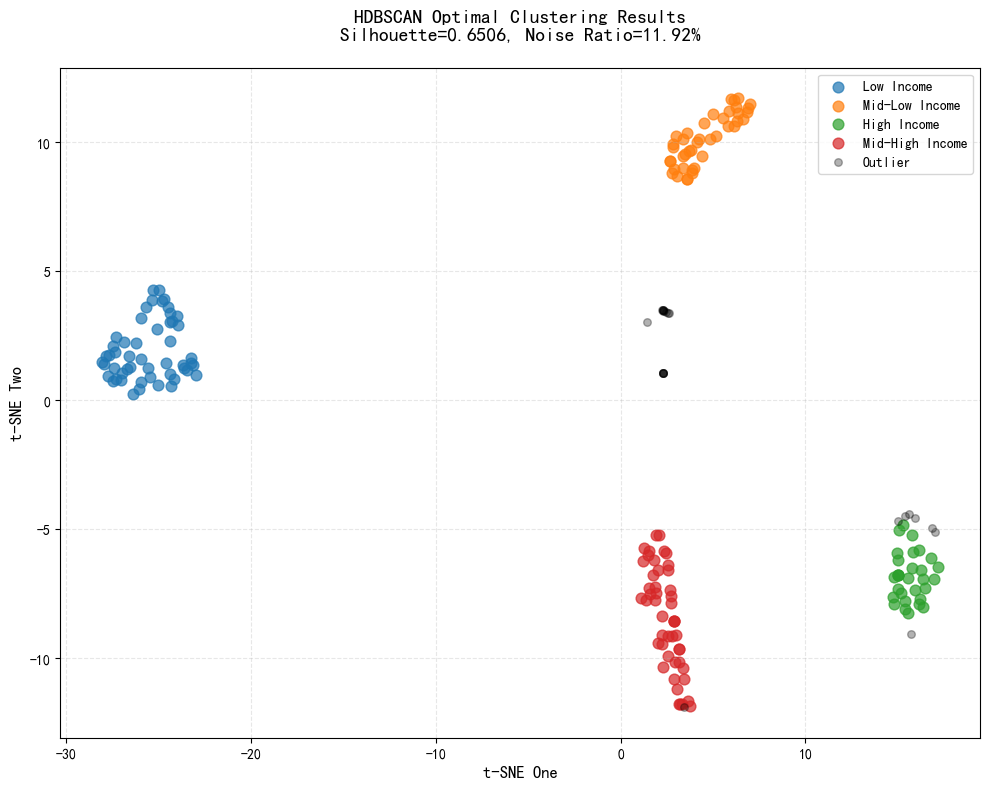

In [62]:
# t-SNE降维（仅用于可视化，不影响聚类结果）
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(data_hdbscan.values)

# 构建可视化数据（合并t-SNE坐标与最优标签）
vis_df = pd.DataFrame({
    't-SNE One': tsne_result[:, 0],
    't-SNE Two': tsne_result[:, 1],
    'Cluster': best_candidate['cluster_labels']
})

# 绘制聚类散点图（噪声点用黑色标记）
plt.figure(figsize=(10, 8))

Cluster_map = {-1:"Outlier", 0:"Low Income", 1:'Mid-Low Income', 2:'High Income', 3:'Mid-High Income'}
# 绘制有效簇（排除噪声）
for cluster in set(vis_df['Cluster']) - {-1}:
    mask = vis_df['Cluster'] == cluster
    plt.scatter(
        vis_df.loc[mask, 't-SNE One'],
        vis_df.loc[mask, 't-SNE Two'],
        alpha=0.7,
        s=60,
        label=Cluster_map[cluster]
    )
# 绘制噪声点（黑色，透明度降低）
noise_mask = vis_df['Cluster'] == -1
plt.scatter(
    vis_df.loc[noise_mask, 't-SNE One'],
    vis_df.loc[noise_mask, 't-SNE Two'],
    c='black',
    alpha=0.3,
    s=30,
    label=Cluster_map[-1]
)

# 图表样式
plt.xlabel('t-SNE One', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Two', fontsize=12, fontweight='bold')
plt.title(
    f'HDBSCAN Optimal Clustering Results\nSilhouette={best_candidate["silhouette_score"]:.4f}, Noise Ratio={best_candidate["noise_ratio"]:.2%}',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [76]:
for idx, obj in enumerate(clustering_results['Cluster']):
    clustering_results['Cluster'][idx] = Cluster_map[obj]
display(clustering_results)

clustering_results.to_csv('HDBSCAN_Clustered_result.csv', index=False, encoding='utf-8-sig')

C:\Users\18469\AppData\Local\Temp\ipykernel_15272\380545706.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  clustering_results['Cluster'][idx] = Cluster_map[obj]
C:\Users\18469\AppData\Local\Temp\ipykernel_15272\380545706.py:2: SettingWi

,Age Annual Income (k$),AgeGroup_61-69,Annual Income (k$),IncomeBin_Q1,IncomeBin_Q2,IncomeBin_Q3,Income_per_Age,Cluster,Age
0,-1.699593,-0.290292,-1.866777,1.646675,-0.591312,-0.623289,-1.137799,Low Income,21
1,-1.655382,-0.290292,-1.825592,1.646675,-0.591312,-0.623289,-1.158515,Low Income,23
2,-1.522749,-0.290292,-1.784407,1.646675,-0.591312,-0.623289,-1.322240,Low Income,31
3,-1.650377,-0.290292,-1.784407,1.646675,-0.591312,-0.623289,-1.072825,Low Income,22
4,-1.436830,-0.290292,-1.743222,1.646675,-0.591312,-0.623289,-1.360152,Low Income,35
...,...,...,...,...,...,...,...,...,...
188,1.148263,-0.290292,2.169371,-0.607284,-0.591312,-0.623289,1.875047,High Income,33
189,1.619569,-0.290292,2.169371,-0.607284,-0.591312,-0.623289,1.374131,High Income,38
190,2.742362,-0.290292,2.457667,-0.607284,-0.591312,-0.623289,0.906640,Outlier,47
191,1.541157,-0.290292,2.457667,-0.607284,-0.591312,-0.623289,1.879860,High Income,35
